# Lending Club Prediction

### Load Data Preparation Class Object

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from joblib import dump, load
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


class DataPreparation:
  def __init__(self, data_path):
        self.df_path = data_path
        self.df = pd.DataFrame()
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

  def load_data(self):
    try:
        # Load dataset and store in class attribute
        self.df = pd.read_csv(self.df_path, index_col='id')
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None


  import re

  def clean_title(self):
        # Define a dictionary with regex patterns for more precise matching
        title_mappings = {
            r'\b(?:debt consolodation|debt consolidation loan|dept consolidation|'
            r'debt con|debt cons|debt consolidate|consolidate debt|'
            r'debt_consolidation|debit consolidation|debt consol|'
            r'debt consilidation|debtconsolidation|debt cosolidation|'
            r'my debt consolidation|consolidating debt|debt pay off|'
            r'get out of debt|pay off debt|debt relief|debt reduction|'
            r'debt payoff)\b': 'debt consolidation',

            r'\b(?:consolidation loan|consolidate|consolidated|'
            r'consolidation for engagement|loan consolidation)\b': 'consolidation',

            r'\b(?:credit cards|cc consolidation|credit consolidation|'
            r'credit card debt consolidation|credit card consolidation loan|'
            r'consolidate credit cards|credit debt|consolidate bills|'
            r'credit card loan|card consolidation|creditcard|creditcards)\b': 'credit card consolidation',

            r'\b(?:credit card refinance|credit refi|credit card refinance loan|'
            r'cc refinance|credit card refi|cc refi|credit refinance|'
            r'card refinance)\b': 'credit card refinancing',

            r'\b(?:ccpayoff|pay off credit card|card payoff|'
            r'after college credit card payoffs|credit card payoff - no late/missed pmts|'
            r'cc loan|cc payoff|credit card debt|credit card pay off|'
            r'pay off credit cards|payoff credit cards|credit card payoff loan|'
            r'credit card repayment|no more credit cards|credit card|pay bills|'
            r'credit payoff|bill payoff|pay off bills|cards|credit card payment|'
            r'cc|cc debt|credit loan|paying off credit cards|bill consolidation)\b': 'credit card payoff',

            r'\b(?:car financing|auto loan|car loan|car)\b': 'car financing',

            r'\b(?:home buying|home loan|improvement|house|swimming pool|'
            r'home|home improvement loan|home improvements)\b': 'home improvement',

            r'\b(?:moving|moving loan|moving expenses)\b': 'moving and relocation',

            r'\b(?:business loan|small business loan)\b': 'business',

            r'\b(?:lending club loan|lc loan|lendingclub)\b': 'lending club',

            r'\b(?:medical|medical loan|medical bills)\b': 'medical expenses'
        }

        # Concat 'title' and 'purpose' for vectorisation (Brian)
        self.df['title_purpose'] = self.df['title'] + ' ' + self.df['purpose']

        # Fill missing values with empty strings before processing
        self.df['title'] = self.df['title'].fillna('')

        # Normalize titles: replace underscores, convert to lowercase, and strip whitespace
        self.df['title'] = self.df['title'].str.replace('_', ' ').str.lower().str.strip()

        # Replace dirty titles with standardized ones using regex patterns
        for pattern, replacement in title_mappings.items():
            self.df['title'] = self.df['title'].str.replace(pattern, replacement, regex=True)

        # Additional standardizations for specific cases
        self.df['title'] = self.df['title'].str.replace(r'^debt$', 'debt consolidation', regex=True)
        self.df['title'] = self.df['title'].str.replace(r'^personal$', 'personal loan', regex=True)
        self.df['title'] = self.df['title'].str.replace(r'\bpersonal\b', 'personal loan', regex=True)

        # Replace empty strings (if any remain after cleaning) with 'other'
        self.df['title'] = self.df['title'].replace(r'^\s*$', 'other', regex=True)

  # ============ Summarising the Title ================ #

  def tokenize_and_lemmatize(self, text):
        tokens = [word for sentence in sent_tokenize(text) for word in word_tokenize(sentence)]
        filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
        lemmas = [self.lemmatizer.lemmatize(token) for token in filtered_tokens if token]
        return lemmas

  def summarise_titles(self):
        SIMILARITY_THRESHOLD = 0.1  # Threshold value for title similarity

        # Get the main titles based on frequency
        main_titles = self.df['title'].value_counts().loc[lambda x: x > 1500].index.tolist()
        main_titles.append('lending club')

        # Configure and fit TF-IDF Vectorizer
        vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            use_idf=True,
            tokenizer=self.tokenize_and_lemmatize,
            ngram_range=(1, 2)
        )

        # Load the vectorizer
        # vectorizer = joblib.load('vectorizer.pkl')

        X_tfidf = vectorizer.fit_transform(self.df['title'])

        # Vectorize main titles and calculate similarities
        main_title_vectors = vectorizer.transform(main_titles)
        similarities = cosine_similarity(X_tfidf, main_title_vectors)

        # Determine the most similar main title or 'other' based on the threshold
        self.df['title'] = np.array(main_titles)[np.argmax(similarities, axis=1)]
        max_similarity = np.max(similarities, axis=1)
        self.df['title'] = np.where(max_similarity > SIMILARITY_THRESHOLD, self.df['title'], 'other')

        # Save the vectorizer for later use
        dump(vectorizer, 'vectorizer.pkl')

  # ============ End of Summarising the Title ================ #


  def clean_emp_title(self):

        # Copy 'emp_title' to a new column for vectorisation (Brian)
        self.df['emp_title_clean'] = self.df['emp_title'].fillna('others')
        self.df['emp_title_clean'] = self.df['emp_title_clean'].str.lower()
        self.df['emp_title_clean'] = self.df['emp_title_clean'].str.replace(r'[^\w\s]', '', regex=True)

        # Proceed to clean 'emp_title'
        self.df['emp_title'] = self.df['emp_title'].str.lower()
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: re.sub(r'[^a-z\s]', '', x.lower()) if isinstance(x, str) else '')

        # Replace registered nurse to RN
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'RN' if re.findall(r'(nurse|registered nurse|^rn$|[^a-z]rn[^a-z]|^lpn$)', x.lower()) else x)

        # Replace titles with 'Management'
        emp_title_list = ['director', 'supervisor', 'manager', 'analyst', 'engineer',
                          'driver', 'owner', 'assistant', 'accountant', 'clerk', 'associate']
        self.df['emp_title'] = self.df['emp_title'].replace(
            {title: 'Management' for title in emp_title_list}, regex=True
        )

        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Legal' if re.findall(r'(attorney|paralegal|legal)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'First Responder' if re.findall(r'(paramedic|firefighter|police officer|correctional officer|sergeant|sheriff|superintendent|inspector|detective)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Defense' if re.findall(r'(army|usaf|lockheed|defense|air force|navy)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Skilled Technicians' if re.findall(r'(technician|mechanic|machinist|electrician|operator|maintenance|welder|plumber)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Senior Management' if re.findall(r'(president|ceo|vp|cfo|coo|deputy)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Banker' if re.findall(r'(bank|wells fargo|jp morgan|morgan chase|jpm)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Education' if re.findall(r'(principal|instructor|education|teacher|professor|educator|ucsd)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Construction' if re.findall(r'(laborer|labor|foreman|construction|worker)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Sales' if re.findall(r'(account executive|sales)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Food and Beverage' if re.findall(r'(server|bartender|chef|bakery|starbcks|mcdonalds)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Physician' if re.findall(r'(physician|doctor)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Accounting' if re.findall(r'(accounts executive|accountant|controller|bookkeeper|booikkeeper|accounting)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Civil Servants' if re.findall(r'(civil|state of|government|department of|investigator)', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Office Executives' if re.findall(r'clerk|admin|officer|secretary|assistant', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Customer Service' if re.findall(r'receptionist|cashier|walmart|customer|teller', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Postal Service' if re.findall(r'usps|dispatcher|postal|letter|^ups$|courier|mail', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Aviation' if re.findall(r'flight|pilot|captain', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Real Estate' if re.findall(r'realtor|estate|housing', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Consulting' if re.findall(r'consultant|partner|advisory|macdonaldbedford', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Healthcare Therapist' if re.findall(r'therapist|counselor', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Healthcare' if re.findall(r'pharmacist|dental|kaiser permanente', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Management' if re.findall(r'management|coordinator|project|team lead', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Financial Advisory' if re.findall(r'financial advisor|wealth manage|custodian', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Telco' if re.findall(r'^att$|verizon|telco', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'Insurance' if re.findall(r'insurance', x.lower()) else x)
        self.df["emp_title"] = self.df["emp_title"].apply(lambda x: 'IT Specialist' if re.findall(r'(software|it|ibm|tech|programmer|developer|web)', x.lower()) else x)

        # Get the top 50 most frequent emp_title values
        top_50_titles = self.df["emp_title"].value_counts().sort_values(ascending=False).reset_index()[:50]["emp_title"].unique()

        # Convert top_50_titles to a set
        top_50_set = set(top_50_titles)

        # Replace values not in the top 50 with 'Other'
        self.df["emp_title"] = self.df["emp_title"].where(self.df["emp_title"].isin(top_50_set), 'Other')

        # Fill missing values in emp_title with empty strings
        self.df['emp_title'] = self.df['emp_title'].fillna('')


  def clean_data(self):

        # Extract state and zip code from address
        self.df['state'] = self.df['address'].str.extract(r'([A-Z]+)\s[0-9]+$')
        self.df['zip_code'] = self.df['address'].str.extract(r'\s([0-9]+)$')

        # Convert categorical to numeric - extract numeric part from emp_length
        self.df['emp_length'] = self.df['emp_length'].replace('< 1 year', '0 year')
        self.df['emp_length'] = self.df['emp_length'].str.extract(r'(\d+)').astype(float)
        self.df['emp_length'] = self.df['emp_length'].fillna(0)

        # Replace loan grade and sub-grade to ordinal rank
        self.df['grade'] = self.df['grade'].astype('object')
        self.df['sub_grade'] = self.df['sub_grade'].astype('object')


        # ========== Additional Features From Brian Sum ================= #

        # Convert 'loan_status' to boolean where 'Fully Paid' is 0 and 'Charged Off' is 1
        self.df['loan_charged_off'] = self.df['loan_status'].map({'Fully Paid':0, 'Charged Off':1})

        # Extract the digits months from 'term'
        self.df['n_term'] = self.df['term'].str.extract(r'(\d+)').astype(int)

        # New Feature: Total Instalment Payment
        self.df['total_installment'] = self.df['installment'] * self.df['n_term']

        # New Feature: Total Interest
        self.df['total_interest'] = self.df['total_installment'] - self.df['loan_amnt']

        # Remove row where total interest is less than or equal to zero
        self.df = self.df[self.df['total_interest'] > 0]

        # New Feature: Number of monthly installment to repay the loan amount assuming no interest component.
        self.df['n_installmt'] = self.df['loan_amnt'] / self.df['installment']

        # Ordinal encode 'grade' according to set order
        grade_unique = [x for x in self.df['grade'].unique()]
        grade_unique.sort()

        ordinal_encoder = OrdinalEncoder(categories = [grade_unique])
        self.df['grade_enc'] = ordinal_encoder.fit_transform(self.df[['grade']])

        # For 'sub_grade' extract only the digit
        # Ensure 'sub_grade' is of type string before using .str accessor
        self.df['sub_grade_enc'] = self.df['sub_grade'].astype(str).str.extract(r'(\d+)')  # Convert to string
        self.df['sub_grade_enc'] = self.df['sub_grade_enc'].fillna(0).astype(int)

        # For 'home_ownership', group class "ANY", "NONE" into "OTHER"
        self.df['home_ownership'] = self.df['home_ownership'].replace(['ANY', 'NONE'], 'OTHER')

        # For 'verification_status' convert to boolean where "Verified" and "Source Verified" is 1
        # and "Not Verified" is 0
        self.df['verification_status'] = self.df['verification_status'].map({'Verified':1, 'Source Verified':1, 'Not Verified':0})

        # Convert 'issue_d' into upper case and then to datetime type
        self.df['issue_d'] = self.df['issue_d'].str.upper()
        self.df['issue_d'] = pd.to_datetime(self.df['issue_d'], format='%b-%Y')

        # Convert 'earliest_cr_line' into upper case and then to datetime type
        self.df['earliest_cr_line'] = self.df['earliest_cr_line'].str.upper()
        self.df['earliest_cr_line'] = pd.to_datetime(self.df['earliest_cr_line'], format='%b-%Y')

        # Based on 'issued_d' calculate the 'credit_age' by number of years
        self.df['credit_age'] = (self.df['issue_d'] - self.df['earliest_cr_line']).dt.days
        self.df['credit_age'] = self.df['credit_age'] / 365

        # New Feature: Total Debt based on 'dti' multiply by 'annual_inc'
        self.df['total_debt'] = self.df['dti'] * self.df['annual_inc']


        # Fill missing values for 'pub_rec', 'mort_acc' and 'pub_rec_bankruptcies'
        self.df['pub_rec'] = self.df['pub_rec'].fillna(0)
        self.df['mort_acc'] = self.df['mort_acc'].fillna(0)
        self.df['pub_rec_bankruptcies'] = self.df['pub_rec_bankruptcies'].fillna(0)


        # Function to remove duplicated words
        def remove_deduplicate(row):
          row = str(row)
          words = row.split()
          unique_words = []
          seen = set()
          for word in words:
              if word not in seen:
                  unique_words.append(word)
                  seen.add(word)
          return ' '.join(unique_words)


        # Concat 'title_purpose'
        self.df['title_purpose'] = self.df['title_purpose'].str.lower()
        self.df['title_purpose'] = self.df['title_purpose'].str.replace(r'[^\w\s]', '', regex=True) # only characters and space
        self.df['title_purpose'] = self.df['title_purpose'].str.replace(r'\b\w{1,2}\b', '', regex=True) # remove words with 1 or 2 characters from a string
        self.df['title_purpose'] = self.df['title_purpose'].str.replace(r'\s+', ' ', regex=True) # remove multiple spaces
        self.df['title_purpose'] = self.df['title_purpose'].str.strip() # remove leading and trailing spaces
        self.df['title_purpose'] = self.df['title_purpose'].str.replace(r'\_', ' ', regex=True) # remove underscores
        self.df['title_purpose'] = self.df['title_purpose'].fillna('others')
        self.df['title_purpose'] = self.df['title_purpose'].apply(remove_deduplicate)

        # Clean the 'address'
        self.df['address_clean'] = self.df['address'].str.lower()
        self.df['address_clean'] = self.df['address_clean'].str.replace(r'[^\w\s]', '', regex=True) # only 5-digit number (postal code), characters and space
        self.df['address_clean'] = self.df['address_clean'].str.replace(r'\b\w{1,2}\b', '', regex=True) # remove words with 1 or 2 characters
        self.df['address_clean'] = self.df['address_clean'].str.replace(r'\s+', ' ', regex=True) # remove multiple spaces
        self.df['address_clean'] = self.df['address_clean'].str.strip() # remove leading and trailing spaces
        self.df['address_clean'] = self.df['address_clean'].str.replace(r'\_', ' ', regex=True) # remove underscores
        self.df['address_clean'] = self.df['address_clean'].apply(remove_deduplicate)

        # Find a 5-digit number (postal code) anywhere in the address from end and extract into 'zip_code'
        self.df['postal_code'] = self.df['address_clean'].str.extract(r'(\d{5})[^0-9]*$', expand=False)
        self.df['postal_code'] = self.df['postal_code'].str.strip()
        self.df['postal_code'] = self.df['postal_code'].fillna('unknown')

        # Extract only text from 'address_clean'
        self.df['address_text'] = self.df['address_clean'].str.replace(r'\d+', '', regex=True)
        self.df['address_text'] = self.df['address_text'].str.replace(r'[^\w\s]', '', regex=True)
        self.df['address_text'] = self.df['address_text'].str.replace(r'\s+', ' ', regex=True) # remove multiple spaces


        # add 'unit', 'box' to stop_words
        self.stop_words.update(['box', 'row'])

        # Clean address_text
        self.df['address_text'] = self.df['address_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in self.stop_words]))
        self.df['address_text'] = self.df['address_text'].str.strip() # remove leading and trailing spaces
        self.df['address_text'] = self.df['address_text'].fillna('')
        self.df['address_text'].head()


        # Remove rows with Nan from 'revol_util'
        self.df = self.df.dropna(subset=['revol_util'])


  def preprocess(self):
        self.load_data()
        if self.df is not None:
            self.clean_title()
            self.summarise_titles()
            self.clean_emp_title()
            self.clean_data()
            return self.df
        else:
            return None


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/briansum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/briansum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/briansum/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briansum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load, Clean and Split Data into Train and Test Sets

In [2]:
# Path to dataset
#database_path = '/content/drive/MyDrive/Colab Notebooks/NYP_Colab/Projects/lending_club/lc_dataset.csv'
#database_path = 'lc_dataset.csv'
database_path = 'https://raw.githubusercontent.com/sumkh/Lending_Club_ITI105_Project/main/datasets/lc_dataset.csv'


# Load data from database, clean, add features and split
data_preparer = DataPreparation(database_path)
df = data_preparer.preprocess()

/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [3]:
# Drop features that are no longer required
data = df.drop(['installment', 'total_installment',
                    'issue_d', 'earliest_cr_line', 'pub_rec_bankruptcies',
                    'term', 'purpose', 'grade', 'sub_grade',
                    'address', 'address_clean', 'zip_code',
                    'loan_status'], axis=1)

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 315730 entries, T0 to T316823
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            315730 non-null  float64
 1   int_rate             315730 non-null  float64
 2   emp_title            315730 non-null  object 
 3   emp_length           315730 non-null  float64
 4   home_ownership       315730 non-null  object 
 5   annual_inc           315730 non-null  float64
 6   verification_status  315730 non-null  int64  
 7   title                315730 non-null  object 
 8   dti                  315730 non-null  float64
 9   open_acc             315730 non-null  float64
 10  pub_rec              315730 non-null  float64
 11  revol_bal            315730 non-null  float64
 12  revol_util           315730 non-null  float64
 13  total_acc            315730 non-null  float64
 14  initial_list_status  315730 non-null  object 
 15  application_type    

In [5]:
# Separate X and Y sets
X = data.drop('loan_charged_off', axis=1)
y = data['loan_charged_off']

# Split the data into Train and Test sets stratify by y
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Run this to reduce the size of the dataset for experimentation
#X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=400, train_size=2000, random_state=42, stratify=y)

In [7]:
# Duplicate a copy of X_train and X_test
X_train = X_train_.copy()
X_test = X_test_.copy()

# Downsample majority class from dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 'auto')
X_train, y_train = rus.fit_resample(X_train, y_train)

# Extract 'loan_amnt' from X_train and X_test for later use and drop from X_train and X_test
X_train_loan_amnt = X_train[['loan_amnt']]
X_test_loan_amnt = X_test[['loan_amnt']]
X_train = X_train.drop('loan_amnt', axis=1)
X_test = X_test.drop('loan_amnt', axis=1)




In [8]:
# Print shape of Train and Test Set
print('Training Set:')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print('Test Set:')
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

# Total data from resampling
total_row = X_train.shape[0] + X_test.shape[0]
print(f"Total data from resampling: {total_row}")


# Proportion of Train and Test Split (after resampling)
print(f"Proportion of Train Split (after resampling): {X_train.shape[0]/total_row:.2f}")
print(f"Proportion of Test Split  (after resampling): {X_test.shape[0]/total_row:.2f}\n")

# Total data from Original (before resampling)
print(f"Total original data before resampling: {len(data)}")
print(f"Total number of rows in X_train removed (Fully Paid class): {len(data)-total_row} or {(len(data)-total_row)/len(data):.2f}")

# Proportion of Train and Test Split
print(f"Proportion of Train Split (based on original data): {len(X_train)/len(data):.2f}")
print(f"Proportion of Test Split  (based on original data): {len(X_test)/len(data):.2f}")

print('\n======================================================\n')

# Proportion of y_train
counts = Counter(y_train)
print(f"Proportion of Fully Paid (train set): {counts[0]/len(y_train):.2f}")
print(f"Proportion of Charged Off (train set): {counts[1]/len(y_train):.2f}")
unique_values, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique_values, counts)))

print('\n======================================================\n')

# Count value for y_test
counts = Counter(y_test)
print(f"Proportion of Fully Paid (test set): {counts[0]/len(y_test):.2f}")
print(f"Proportion of Charged Off (test set): {counts[1]/len(y_test):.2f}")
unique_values, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique_values, counts)))


Training Set:
X_train shape: (99348, 28)
y_train shape: (99348,)

Test Set:
X_test shape: (63146, 28)
y_test shape: (63146,)

Total data from resampling: 162494
Proportion of Train Split (after resampling): 0.61
Proportion of Test Split  (after resampling): 0.39

Total original data before resampling: 315730
Total number of rows in X_train removed (Fully Paid class): 153236 or 0.49
Proportion of Train Split (based on original data): 0.31
Proportion of Test Split  (based on original data): 0.20


Proportion of Fully Paid (train set): 0.50
Proportion of Charged Off (train set): 0.50
{0: 49674, 1: 49674}


Proportion of Fully Paid (test set): 0.80
Proportion of Charged Off (test set): 0.20
{0: 50728, 1: 12418}


### Model Training

#### Load Libraries

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import (
    KFold,
    RepeatedStratifiedKFold,
    cross_validate,
    cross_val_predict,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec

from sklearn.metrics import (
    roc_auc_score,
    auc,
    roc_curve,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix
    )

import mlflow
#import shap
from mlflow.models import infer_signature
from mlflow.models import MetricThreshold

import time
import warnings
import logging
from contextlib import contextmanager

#logging.getLogger("mlflow").setLevel(logging.ERROR) 
warnings.filterwarnings('ignore')

# Define a context manager to temporarily set the logging level.
@contextmanager
def set_logging_level(logger_name, level):
    logger = logging.getLogger(logger_name)
    previous_level = logger.level
    logger.setLevel(level)
    try:
        yield
    finally:
        logger.setLevel(previous_level)


#### Custom Transformer for Vector Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler

# Custom Transformer for Vector Preprocessing

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=50):
        self.vector_size = vector_size
        self.model = None

    def fit(self, X, y=None):
        # X is the DataFrame containing the text columns
        corpus_list = X.apply(lambda x: x.split()).tolist() # Convert each row to a list of words
        self.model = Word2Vec(
            sentences=corpus_list, # Input corpus: list of sentences
            vector_size=self.vector_size, # Dimensionality of the word vectors
            window=5, # Context window size
            min_count=1, # Minimum frequency count of words to consider
            workers=4 # Number of worker threads for training
        )
        return self

    def get_mean_vector(self, words):
            valid_words = [word for word in words if word in self.model.wv] # Filter out words that are not in the model's vocabulary
            if not valid_words:
                return np.zeros(self.vector_size)
            return np.mean([self.model.wv[word] for word in valid_words], axis=0) # Return vectors from words

    def transform(self, X):
        return pd.DataFrame(X.apply(lambda words: self.get_mean_vector(words.split())).tolist())

    def get_feature_names_out(self, input_features=None):
        return [f"{i}" for i in range(self.vector_size)]



# Function to create a vectorizer preprocessor with dynamic vector_size
def create_vec_preprocessor(vector_size_emp, vector_size_purpose):
    return ColumnTransformer(
        transformers=[
            ('emp', Word2VecVectorizer(vector_size=vector_size_emp), 'emp_title_clean'),
            ('purpose', Word2VecVectorizer(vector_size=vector_size_purpose), 'title_purpose'),
            #('address', Word2VecVectorizer(vector_size=vector_size), 'address_text'),
        ],
        remainder='passthrough' # Use 'passthrough' for columns not specified
        )

# Define function to convert vector preprocessed data into dataframe
def vec_to_df(X_train, X_train_transformed, vec_preprocessor):
    feature_names = vec_preprocessor.get_feature_names_out()
    pattern = re.compile(r'remainder__')
    feature_names = [pattern.sub('', i ) for i in feature_names]

    # Transform back to dataframe with the features names
    X_train_df = pd.DataFrame(X_train_transformed, columns = feature_names, index=X_train.index)

    return X_train_df

#### (Optional) Check Custom Transformer

In [16]:
# Check the vec_preprocessor to ensure it generate dataframe with the correct shape
vector_size = 5

vector_preprocessor_ = create_vec_preprocessor(vector_size)
X_train_transformed_ = vector_preprocessor_.fit_transform(X_train)

expected_shape = (X_train.shape[0], X_train.shape[1]-3 + (vector_size * 3))
print(f"Expected shape: {expected_shape}")
print(f"Actual shape: {X_train_transformed_.shape}")


Expected shape: (99348, 40)
Actual shape: (99348, 40)


In [17]:
feature_text = vector_preprocessor_.get_feature_names_out()
pattern = re.compile(r'remainder__')
feature_text = [pattern.sub('', i ) for i in feature_text]
print(feature_text)

['emp__0', 'emp__1', 'emp__2', 'emp__3', 'emp__4', 'purpose__0', 'purpose__1', 'purpose__2', 'purpose__3', 'purpose__4', 'address__0', 'address__1', 'address__2', 'address__3', 'address__4', 'int_rate', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'title', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'state', 'n_term', 'total_interest', 'n_installmt', 'grade_enc', 'sub_grade_enc', 'credit_age', 'total_debt', 'postal_code']


In [18]:
# Replace the column names with the feature_text
X_train_transformed_ = pd.DataFrame(X_train_transformed_, columns = feature_text)
X_train_transformed_.head()

,emp__0,emp__1,emp__2,emp__3,emp__4,purpose__0,purpose__1,purpose__2,purpose__3,purpose__4,...,mort_acc,state,n_term,total_interest,n_installmt,grade_enc,sub_grade_enc,credit_age,total_debt,postal_code
0,-0.103643,-0.109281,0.054407,0.194053,-0.106049,-0.102972,1.471335,1.482773,-1.000296,-2.022557,...,0.0,VA,36,2177.2,27.942265,3.0,2,7.339726,165690.0,30723
1,0.041977,-0.125537,0.182047,-0.053857,-0.010533,1.059058,1.656232,1.655024,-1.596043,-2.39948,...,0.0,LA,36,2435.64,29.925933,1.0,4,10.424658,1241000.0,29597
2,-2.179078,1.114895,2.373402,-1.994918,-2.446486,-0.102972,1.471335,1.482773,-1.000296,-2.022557,...,2.0,DE,60,15123.6,34.880244,5.0,5,11.50411,925440.0,70466
3,0.070008,0.195363,0.455564,-0.425423,-0.162039,1.077226,1.712355,1.660715,-1.708599,-2.240787,...,0.0,MO,36,2708.36,28.327809,2.0,4,9.345205,897561.6,05113
4,-0.474567,1.900383,2.157423,-1.495256,1.128481,-0.102972,1.471335,1.482773,-1.000296,-2.022557,...,0.0,MO,36,2302.28,29.262868,2.0,4,10.756164,1499990.0,29597


#### (Optional) Extrinsic Evaluation for Best Vectors Size using Logistic Regression

In [24]:
mlflow.sklearn.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)

# Create an empty list to store the results
cvfit_results = []
start_time = time.time()

# Iterate over the vector size
vector_size_grid = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

# Text features list
feature_list = ['emp_title_clean', 'title_purpose', 'address_text']

# Iterate over text features
for feature in feature_list:
  # Iterate over vector size
  for vector_size in vector_size_grid:
    # Instantiate vectorizer
    vectorizer = Word2VecVectorizer(vector_size=vector_size)
    X_train_transformed = vectorizer.fit_transform(X_train[feature])

    # Instantiate Logistic Regression
    lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100)

    print(f"\nTraining LR with {feature} of vector_size {vector_size}...")
    lr_result = cross_validate(lr, X_train_transformed, y_train,
                          cv=2, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=1)

    print(f'mean train score: {lr_result["train_score"].mean():.3f}, mean val score: {lr_result["test_score"].mean():.3f}')

    for i in range(len(lr_result['train_score'])):
        cvfit_results.append({
            'fit_index': i,
            'train_score': lr_result['train_score'][i],
            'val_score': lr_result['test_score'][i],
            'vector_size': vector_size,
            'feature': feature,
        })

end_time = time.time()
print(f"Total time (training + evaluation): {end_time - start_time:.2f} seconds")



Training with vector_size 10...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s finished


mean train score: 0.553, mean val score: 0.552

Training with vector_size 20...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.7s finished


mean train score: 0.562, mean val score: 0.560

Training with vector_size 30...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.2s finished


mean train score: 0.564, mean val score: 0.561

Training with vector_size 40...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.7s finished


mean train score: 0.567, mean val score: 0.563

Training with vector_size 50...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.4s finished


mean train score: 0.568, mean val score: 0.565

Training with vector_size 60...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.0s finished


mean train score: 0.569, mean val score: 0.564

Training with vector_size 70...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   38.2s finished


mean train score: 0.570, mean val score: 0.566

Training with vector_size 80...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.0s finished


mean train score: 0.570, mean val score: 0.565

Training with vector_size 90...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


mean train score: 0.572, mean val score: 0.568

Training with vector_size 100...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


mean train score: 0.573, mean val score: 0.568

Training with vector_size 110...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


mean train score: 0.572, mean val score: 0.568

Training with vector_size 120...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


mean train score: 0.573, mean val score: 0.568

Training with vector_size 130...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min finished


mean train score: 0.572, mean val score: 0.567

Training with vector_size 140...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   58.6s finished


mean train score: 0.574, mean val score: 0.568

Training with vector_size 150...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.2min finished


mean train score: 0.573, mean val score: 0.568

Training with vector_size 10...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished


mean train score: 0.555, mean val score: 0.555

Training with vector_size 20...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.8s finished


mean train score: 0.562, mean val score: 0.561

Training with vector_size 30...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   56.9s finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 40...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   58.9s finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 50...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min finished


mean train score: 0.564, mean val score: 0.562

Training with vector_size 60...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.8min finished


mean train score: 0.564, mean val score: 0.563

Training with vector_size 70...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.0min finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 80...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min finished


mean train score: 0.563, mean val score: 0.563

Training with vector_size 90...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.3min finished


mean train score: 0.564, mean val score: 0.562

Training with vector_size 100...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 58.2min finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 110...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 57.7min finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 120...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 20.3min finished


mean train score: 0.564, mean val score: 0.562

Training with vector_size 130...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 27.4min finished


mean train score: 0.564, mean val score: 0.562

Training with vector_size 140...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 26.5min finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 150...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.1min finished


mean train score: 0.563, mean val score: 0.562

Training with vector_size 10...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 20...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.9s finished


mean train score: 0.511, mean val score: 0.498

Training with vector_size 30...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   55.3s finished


mean train score: 0.513, mean val score: 0.498

Training with vector_size 40...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   28.3s finished


mean train score: 0.512, mean val score: 0.498

Training with vector_size 50...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   48.7s finished


mean train score: 0.513, mean val score: 0.497

Training with vector_size 60...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   28.9s finished


mean train score: 0.511, mean val score: 0.498

Training with vector_size 70...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/briansum/My Drive/Colab Notebooks/NYP_Colab/Projects/lending_club/project105/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.9s finished


mean train score: 0.510, mean val score: 0.498

Training with vector_size 80...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.2s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 90...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.8s finished


mean train score: 0.509, mean val score: 0.498

Training with vector_size 100...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 110...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.9s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 120...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.6s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 130...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.4s finished


mean train score: 0.509, mean val score: 0.497

Training with vector_size 140...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.1s finished


mean train score: 0.509, mean val score: 0.498

Training with vector_size 150...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


mean train score: 0.508, mean val score: 0.497
Total time (training + evaluation): 14257.02 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s finished


Feature: emp_title_clean, Vector Size: 120, Max Mean Val Score: 0.568
Feature: title_purpose, Vector Size: 60, Max Mean Val Score: 0.563
Feature: address_text, Vector Size: 70, Max Mean Val Score: 0.498


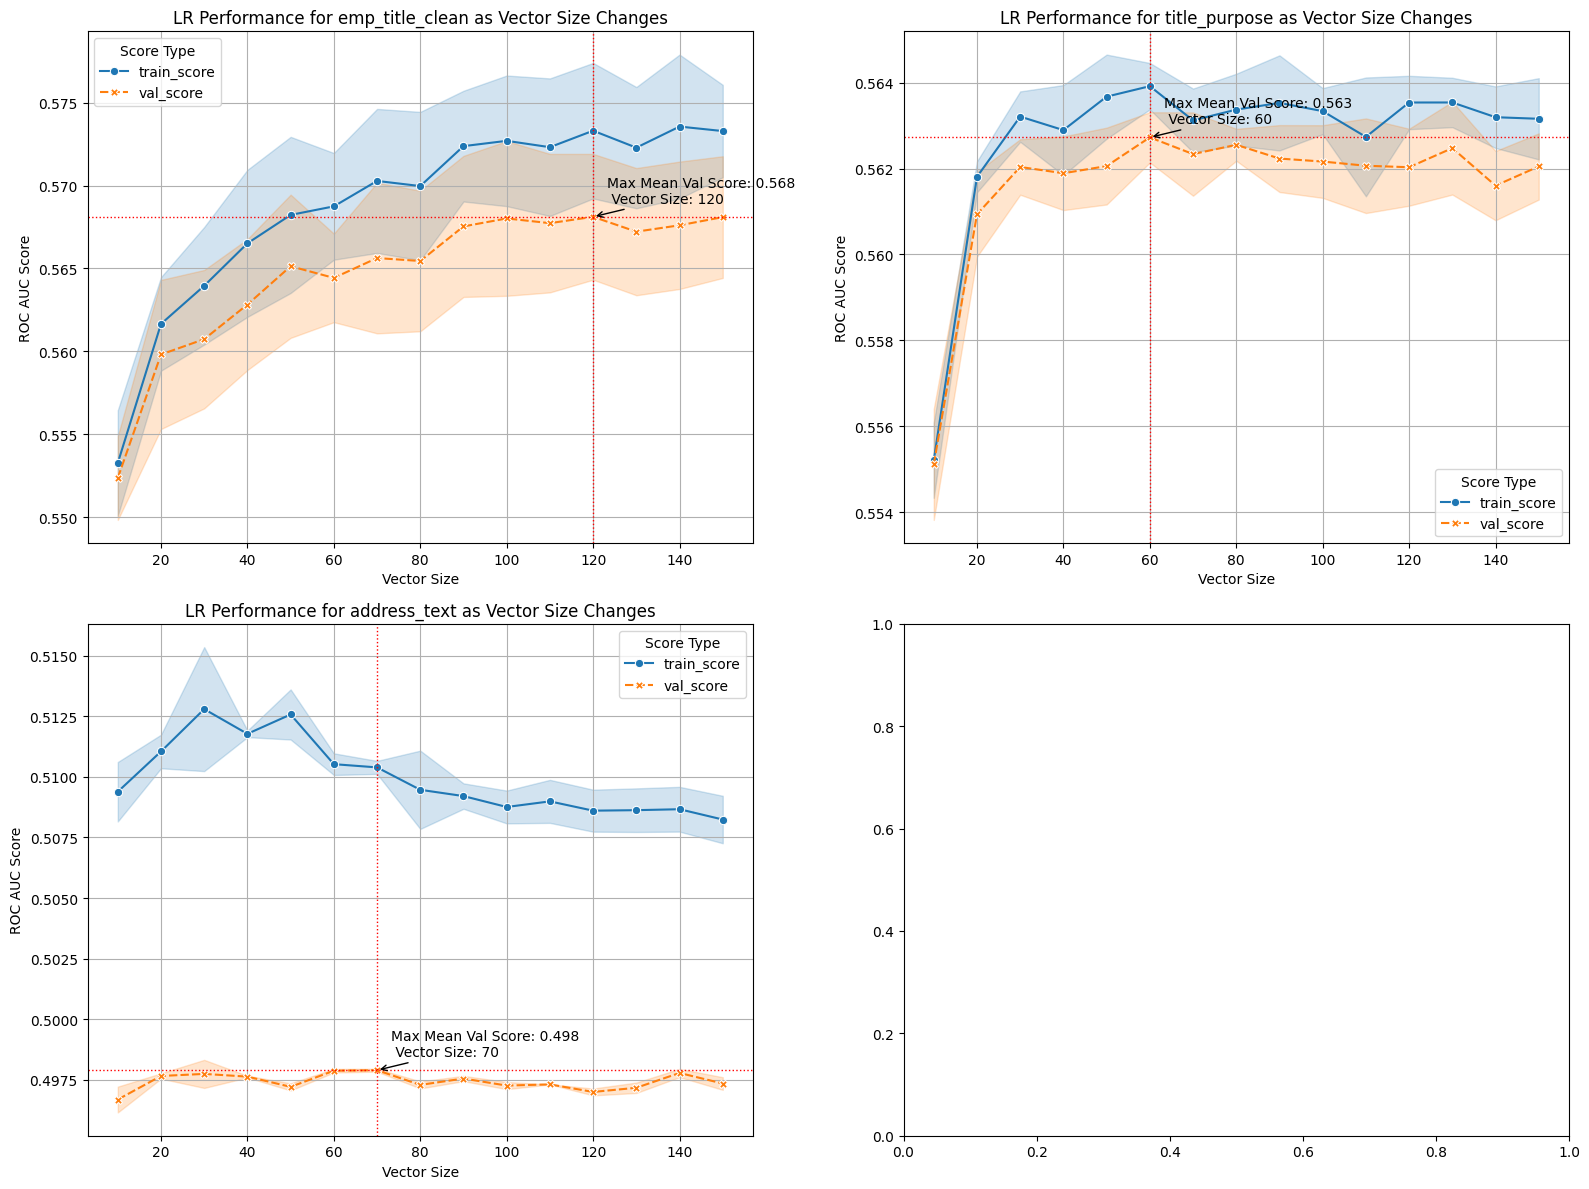

In [34]:
# Convert cv_results to DataFrame and plot
cvfit_results_df = pd.DataFrame(cvfit_results)
melted_df = pd.melt(cvfit_results_df, id_vars=['feature', 'vector_size'], value_vars=['train_score', 'val_score'],
                    var_name='score_type', value_name='score')

# Set up plot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.flatten()

# Iterate over the text features
for i, feature in enumerate(feature_list):
    # Filter the DataFrame for the current text feature
    feature_df = melted_df[melted_df['feature'] == feature]

    # Plot the data for the current feature
    sns.lineplot(data=feature_df, x='vector_size', y='score', hue='score_type', style='score_type', markers=True, ax=ax[i])

    # Find mean validation score for each vector size
    mean_val_score = feature_df[feature_df['score_type'] == 'val_score'].groupby('vector_size')['score'].mean()
    
    # Find the maximum mean validation score and its corresponding vector size for the current feature
    max_val_score = mean_val_score.sort_values(ascending=False).head(1)
    max_val_df = feature_df[(feature_df['vector_size'] == max_val_score.index[0]) & (feature_df['score_type'] == 'val_score')]
    print(f'Feature: {feature}, Vector Size: {max_val_score.index[0]}, Max Mean Val Score: {max_val_score.values[0]:.3f}')

    # Highlight the maximum mean validation score
    ax[i].annotate(f'Max Mean Val Score: {max_val_score.values[0]:.3f}\n Vector Size: {max_val_score.index[0]:.0f}',
                     xy=(max_val_score.index[0], max_val_score.values[0]),
                        xytext=(10, 10),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='black'))
    
    # Draw dotted lines at the vector size with the highest validation score
    ax[i].axvline(x=max_val_score.index[0], color='red', linestyle=':', linewidth=1)
    ax[i].axhline(y=max_val_score.values[0], color='red', linestyle=':', linewidth=1)

    # Set subplot titles and labels
    ax[i].set_title(f'LR Performance for {feature} as Vector Size Changes')
    ax[i].set_xlabel('Vector Size')
    ax[i].set_ylabel('ROC AUC Score')
    ax[i].grid(True)
    ax[i].legend(title='Score Type')

plt.tight_layout()
plt.show()


Base on the above, using address text word embedding does not offer improvement to the prediction as the validation score for ROC-AUC is below 50%. For employment title and purpose text word embedding, use of 120 and 60 respectively. There are more preplexity in the employment title as compared to the purpose and hence warranted higher vector space to represent the features. Whereas, for address, there is limited sementics between the address and therefore, the word embedding do not yield much variation to the logistic regression model.

In [85]:
mlflow.sklearn.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)

# Create Pipeline for Logistic Regression
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', max_iter=100))
])

# Cross Validate a logistic regression model with only emp_title without vectorization
lr_result = cross_validate(pipe, X_train[['emp_title']], y_train,
                          cv=2, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=1)
                          
# print the mean train and validation score
print("Cross Validation Results for Logistic Regression with emp_title without vectorization")
print(f'mean train score: {lr_result["train_score"].mean():.3f}, mean val score: {lr_result["test_score"].mean():.3f}')
print('\n======================================================\n')

# Create Pipeline for Logistic Regression
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear', max_iter=100))
])

# Cross Validate a logistic regression model with only title_purpose without vectorization
lr_result = cross_validate(pipe, X_train[['title']], y_train,
                          cv=2, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=1)

# print the mean train and validation score
print("Cross Validation Results for Logistic Regression with title without vectorization")
print(f'mean train score: {lr_result["train_score"].mean():.3f}, mean val score: {lr_result["test_score"].mean():.3f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Cross Validation Results for Logistic Regression with emp_title without vectorization
mean train score: 0.542, mean val score: 0.538


Cross Validation Results for Logistic Regression with title without vectorization
mean train score: 0.548, mean val score: 0.548


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished


Using Word2Vec Embedding as features for "emp_title" and "title" offer some improvement to the validation roc-auc score under a simple logistic regression algorithm. Therefore I will continue to use the approach of using word embedding as text feature.

#### (Optional) Visualize Word Embedding

Principal Component Analysis or PCA is a classical projection methods to reduce the high-dimensional word vectors to 2 dimensional plot and plot them on a graph. (Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

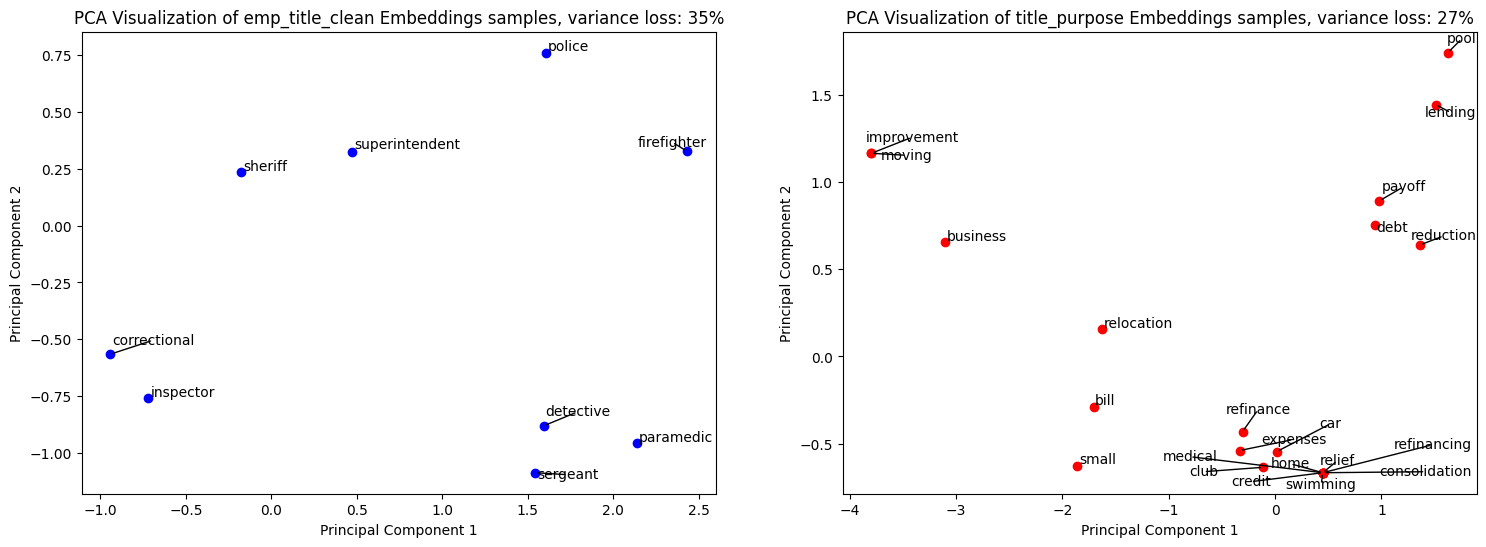

In [75]:
from sklearn.decomposition import PCA
from adjustText import adjust_text
mlflow.sklearn.autolog(disable=True)
mlflow.xgboost.autolog(disable=True)

# Vectorize 'emp_title_clean' and 'title_purpose'
vectorizer_emp = Word2VecVectorizer(vector_size=120)
X_train_emp = vectorizer_emp.fit_transform(X_train['emp_title_clean'])

vectorizer_purpose = Word2VecVectorizer(vector_size=60)
X_train_purpose = vectorizer_purpose.fit_transform(X_train['title_purpose'])

# Initialize separate PCA for each dataset
pca_emp = PCA(n_components=2)
pca_purpose = PCA(n_components=2)

# Fit PCA to the respective word vectors and transform
reduced_emp = pca_emp.fit_transform(X_train_emp)
reduced_purpose = pca_purpose.fit_transform(X_train_purpose)

# Calculate the variance loss due to PCA
explained_variance_emp = pca_emp.explained_variance_ratio_.sum()
variance_loss_emp = (1 - explained_variance_emp) * 100

explained_variance_purpose = pca_purpose.explained_variance_ratio_.sum()
variance_loss_purpose = (1 - explained_variance_purpose) * 100

# Visualize the reduced embeddings
# Select a subset of words for visualization
emp_title_list = ['paramedic','firefighter','police','correctional','sergeant',
                    'sheriff','superintendent','inspector','detective']

title_purpose_list = ['debt', 'consolidation', 'relief', 'reduction', 
                        'credit','refinancing', 'refinance', 
                        'payoff', 'car', 'bill',
                        'improvement', 'home', 'swimming', 'pool', 
                        'moving', 'relocation', 
                        'business', 'small', 
                        'medical', 'expenses', 
                        'lending', 'club']

# Get the respective text features corresponding reduced embeddings
emp_title_word_indices = [vectorizer_emp.model.wv.key_to_index[w] for w in emp_title_list]
selected_emp_title_embeddings = reduced_emp[emp_title_word_indices]

title_purpose_word_indices = [vectorizer_purpose.model.wv.key_to_index[w] for w in title_purpose_list]
selected_title_purpose_embeddings = reduced_purpose[title_purpose_word_indices]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Emp title embeddings
emp_texts = []
for i, word in enumerate(emp_title_list):
    emp_texts.append(ax[0].text(selected_emp_title_embeddings[i, 0], selected_emp_title_embeddings[i, 1], word))
ax[0].scatter(selected_emp_title_embeddings[:, 0], selected_emp_title_embeddings[:, 1], color='blue')
ax[0].set_title('PCA Visualization of emp_title_clean Embeddings samples, variance loss: {:.0f}%'.format(variance_loss_emp))
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
adjust_text(emp_texts, ax=ax[0], expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
            arrowprops=dict(arrowstyle='-', color='k'), force_points=0.5, force_text=0.5, iterations=50)

# Title purpose embeddings
purpose_texts = []
for i, word in enumerate(title_purpose_list):
    purpose_texts.append(ax[1].text(selected_title_purpose_embeddings[i, 0], selected_title_purpose_embeddings[i, 1], word))
ax[1].scatter(selected_title_purpose_embeddings[:, 0], selected_title_purpose_embeddings[:, 1], color='red')
ax[1].set_title('PCA Visualization of title_purpose Embeddings samples, variance loss: {:.0f}%'.format(variance_loss_purpose))
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
adjust_text(purpose_texts, ax=ax[1], expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
            arrowprops=dict(arrowstyle='-', color='k'), force_points=0.5, force_text=0.5, iterations=50)

plt.show()

Using PCA could be helpful to reduce the high-dimensional word vectors to 2 dimensional plot and the above plot do show some sample of associated words are plotted "closer" with one another. Will use PCA to reduce the high-dimensional word vectors to 1 dimensional to enhance of the preformance of model training. First I will iterate through against a range of vector size as above but reduce the vector space to 2 dimensional vector embeddings.

#### Setting up Models Training Configurations and Data Preprocessing

Important:
To begin MLFlow, run the following at Terminal first before logging in notebook.
```bash
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./mlruns \
    --host 127.0.0.1 \
    --port 8080
```
This will generate a sqlite db filename "mlflow.db" to save all the data into a local device db database. Avoid saving data locally as files as you may encounter errors.

In [11]:
import mlflow

db_path = "mlflow.db"

# Set the tracking URI to your SQLite database file
mlflow.set_tracking_uri(f'sqlite:///{db_path}')

# set the experiment
mlflow.set_experiment("MLflow_BrianSum")

<Experiment: artifact_location=('/Users/briansum/My Drive/Colab '
 'Notebooks/NYP_Colab/Projects/lending_club/mlruns/2'), creation_time=1724121614226, experiment_id='2', last_update_time=1724121614226, lifecycle_stage='active', name='MLflow_BrianSum', tags={}>

In [12]:
# Drop the 'emp_title' and 'title' features
X_train = X_train.drop(['address_text', 'emp_title', 'title'], axis=1)

# Drop the 'address_text', 'emp_title' and 'title' features from X_test
X_test = X_test.drop(['address_text', 'emp_title', 'title'], axis=1)

In [13]:
# Determine the list of numerical and categorical features
cat_var = X_train.select_dtypes(include=['object']).columns
num_var = X_train.select_dtypes(include=['float64', 'int64', 'int', 'bool']).columns

# Drop 'emp_title_clean', 'title_purpose', 'address_text' from cat_var
cat_var = cat_var.drop(['emp_title_clean', 'title_purpose'])

# Define the model and respective hyperparameters search space and train the models
model_class = {
    #'lr': LogisticRegression,
    'random_forest': RandomForestClassifier,  # Note: no parentheses
    'ada': AdaBoostClassifier,
    'sgd': SGDClassifier,
    }

model_params = {
    'random_forest': {
        'model__n_estimators': [100, 200, 300, 500],
        'model__max_depth': [None, 10, 20, 30],
        'model__n_jobs': [-1],
    },
    'ada': {
        'model__n_estimators': [100, 200, 300, 500],
        'model__learning_rate': [0.01, 0.1, 0.2, 0.3, 1.0], # learning rate
        'model__algorithm': ['SAMME'],
    },
    'sgd': {
        'model__loss': ['log_loss', 'modified_huber'],
        'model__penalty': ['l1', 'elasticnet'],
        'model__learning_rate': ['optimal', 'adaptive'],
        'model__eta0': [0.01, 0.1, 1],  # Ensure eta0 > 0
        'model__n_jobs': [-1],
    },
}

For the prediction of loan default in this binary classification problem, especially with imbalanced data (minority class of 20%) , Random Forest, AdaBoost Classifier, and SGDClassifier are considered, particularly in conjunction with the data strategy of under-sampling of the majority class (fully paid) versus the minority class (loan charged off):

##### 1. **Random Forest (Bagging Approach):**
   - **Robustness to Imbalanced Data:** Random Forest, an ensemble learning method that combines multiple decision trees to make predictions, is inherently robust to imbalanced datasets because it can handle a large variety of features (including word embeddings vectors) and balances the variance-bias trade-off effectively.
   - **Feature Importance:** Random Forest provides insights into feature importance, which is useful for understanding which factors contribute most to loan default prediction.
   - **Handling Overfitting:** By averaging the predictions of multiple trees, Random Forest reduces the risk of overfitting, which is particularly important in cases where the minority class is underrepresented.
   - **Versatility:** It can capture non-linear relationships and interactions between features, which is beneficial in complex datasets like those used for predicting loan defaults.

##### 2. **XGB and AdaBoost Classifier (Boosting Approach):**
   - **Focus on Hard-to-Classify Examples:** XGBoost and AdaBoost, are ensemble techniques that focuses on improving the performance of weak learners by giving more weight to misclassified instances. In the context of an imbalanced dataset, AdaBoost iteratively adjusts its focus on the minority class (loan charged off), helping to improve the model's sensitivity to this class.
   - **Reduced Bias:** Both XGBoost and AdaBoost can reduce bias and potentially improve the predictive accuracy for the minority class by emphasizing harder-to-predict examples in subsequent rounds of boosting.

##### 3. **SGDClassifier (Linear Model):**
   - **Efficiency with Large Datasets:** The SGDClassifier is based on stochastic gradient descent and is highly efficient for large datasets, especially when combined with under-sampling techniques. It scales well with the number of data points, which is beneficial for loan default prediction where datasets is substantial.
   - **Handling Imbalanced Data:** With the appropriate loss function (i.e, log loss for logistic regression), SGDClassifier can be tuned to perform well on imbalanced datasets. It can be particularly effective in conjunction with class weights or under-sampling to focus on the minority class.

##### **Conclusion:**
Using Random Forest, XGBoost, AdaBoost, and SGDClassifier provides a balanced approach to handling the challenges of an imbalanced dataset in a binary classification problem. Random Forest offers robustness and feature interpretability, XGBoost and AdaBoost focuses on improving performance on difficult-to-classify instances, and SGDClassifier provides efficiency and flexibility for large-scale data. Together, these methods enable a comprehensive exploration of the feature space, model performance, and handling of class imbalance, towards improving the prediction of loan defaults.

In [14]:
# Specify Vector Size
vector_size_emp = 120
vector_size_purpose = 60

# Process Vectors for Textual Features with ColumnTransformer for 'emp_title_clean' and 'title_purpose'
vec_preprocessor = create_vec_preprocessor(vector_size_emp, vector_size_purpose)

# Fit Transform Word Embeddings for Text Features
X_train_transformed = vec_preprocessor.fit_transform(X_train)
X_train_transformed = vec_to_df(X_train, X_train_transformed, vec_preprocessor)

# Transform the test set with the Vectorizer Preprocessor
X_test_transformed = vec_preprocessor.transform(X_test) # Transform only
X_test_transformed = vec_to_df(X_test, X_test_transformed, vec_preprocessor)

# Save vec_processor for later use
dump(vec_preprocessor, 'vec_preprocessor.joblib')

print(f"Shape of X_train_transformed: {X_train_transformed.shape}")
print(f"Shape of X_test_transformed: {X_test_transformed.shape}")


Shape of X_train_transformed: (99348, 203)
Shape of X_test_transformed: (63146, 203)


#### Helper Functions for Model Evaluations

In [15]:
# Define Function to Plot ROC and PRC Curve for each model and return the ROC-AUC, PRC-AUC scores and the figure
def plot_curves(model_name, model_data, X, y):

    # Set Plot Size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Probabilities for positive class
    probas = model_data.predict_proba(X)
    preds = probas[:, 1] # Extract probabilities for positive class

    # ROC Curve and ROC-AUC
    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Precision-Recall Curve and PRC-AUC
    precision, recall, _ = precision_recall_curve(y, preds)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.2f})')

    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    ax2.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")

    plt.tight_layout()
    
    # Save plot as a separate PNG file
    fig_path = f"{model_name}_roc_prc_curves.png"
    fig.savefig(fig_path)
    plt.close(fig)

    return fig_path

    
# Define Function to compute evaluation metrices for each model
def compute_metrices(model_data, X, y):

    # Make predictions on the X
    probas = model_data.predict_proba(X)
    preds = probas[:, 1] # Extract probabilities for positive class

    # Calculate precision-recall curve
    prc = precision_recall_curve(y, preds)
    precisions, recalls, thresholds = prc
    pr_auc = auc(recalls, precisions)

    # ROC Curve and ROC-AUC
    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    
    prc_df = pd.DataFrame(prc)
    prc_df = prc_df.T
    prc_df.columns = ['precision', 'recall', 'threshold']

    # Calculate F1 scores and find index of highest F1 score
    prc_df['Precision_Recall'] = prc_df['precision'] - prc_df['recall']
    prc_df['F1_Score'] = 2 * (prc_df['precision'] * prc_df['recall']) / (prc_df['precision'] + prc_df['recall'])
    prc_df['F1_Score'] = prc_df['F1_Score'].fillna(0)

    # Threshold with highest F1 Score
    highf1_idx = prc_df.loc[prc_df['F1_Score'].idxmax()]
    highf1_threshold = highf1_idx['threshold']
    highf1_f1 = highf1_idx['F1_Score']
    highf1_precision = highf1_idx['precision']
    highf1_recall = highf1_idx['recall']

    # Threshold with balanced precision-recall
    balanced_idx = prc_df.loc[prc_df['Precision_Recall'].abs().idxmin()]
    balanced_threshold = balanced_idx['threshold']
    balanced_f1 = balanced_idx['F1_Score']
    balanced_precision = balanced_idx['precision']
    balanced_recall = balanced_idx['recall']

    # Results Dictionary
    results = {
        'ROC-AUC': roc_auc,
        'PRC-AUC': pr_auc,
        'Optimal_F1_score': highf1_f1,
        'Optimal_Precision': highf1_precision,
        'Optimal_Recall': highf1_recall,
        'Optimal_Threshold': highf1_threshold,
        'Balanced_F1_score': balanced_f1,
        'Balanced_Precision': balanced_precision,
        'Balanced_Recall': balanced_recall,
        'Balanced_Threshold': balanced_threshold,
    }

    return results


def cm_plot(model_data, X, y, threshold, title = None):
    # Make predictions on the X
    probas = model_data.predict_proba(X)
    preds = probas[:, 1] # Extract probabilities for positive class

    # Predictions for thresholds and confusion matrix
    predictions = (preds >= threshold).astype(int)
    cm = confusion_matrix(y, predictions)
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix, based on {title} Threshold: {threshold:.2f}')
    
    # Save plot as a separate PNG file
    fig_path = f"{model_name}_confusion_matrix_{title}_threshold.png"
    fig.savefig(fig_path)
    plt.close(fig)

    return fig_path


#### Training the Models

In [34]:
# Setup cross validation folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42) # default: n_repeats=10, not used as under-sampling is applied

# Concat X_test_transformed with y_test
eval_data = pd.concat([X_test_transformed, y_test], axis=1)

# create signature that is shared by the models
signature = infer_signature(X_test_transformed, y_test)

In [35]:
with mlflow.start_run(run_name='baseline_model'):
    mlflow.sklearn.autolog()
    # train a baseline dummy model
    baseline_model = DummyClassifier(strategy="stratified").fit(X_train_transformed, y_train)
    baseline_model_uri = mlflow.sklearn.log_model(
            baseline_model, "baseline_model", signature=signature).model_uri
mlflow.end_run()

2024/08/21 08:56:43 WARNING mlflow.utils.validation: Tag value '[{"run_id": "ecb0e117fd6f49de8a6cbc1f641c218c", "artifact_path": "model", "utc_time_created": "2024-...' (14621 characters) is truncated to 5000 characters to meet the length limit.
2024/08/21 08:56:44 WARNING mlflow.utils.validation: Tag value '[{"run_id": "ecb0e117fd6f49de8a6cbc1f641c218c", "artifact_path": "model", "utc_time_created": "2024-...' (29243 characters) is truncated to 5000 characters to meet the length limit.


In [16]:
# To temporily disable mlflow warning messages
with set_logging_level("mlflow", logging.ERROR):

    # Create an empty list to store the results
    results = []
    cvfit_results = []
    start_time = time.time()

    # Train the models
    for model_name, params in model_params.items():
        # Start a child run for each model
        with mlflow.start_run(run_name=f"GridSearch_{model_name}", nested=True) as train_run:
            train_run_id = train_run.info.run_id
            mlflow.sklearn.autolog() 

            # Build pipeline from scratch every time they are called.
            # Data preprocessing step with ColumnTransformer
            num_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
                ])
            # Preprocessing for categorical data
            cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', num_transformer, num_var),
                    ('cat', cat_transformer, cat_var),
                ],
                remainder='passthrough', # Use 'passthrough' for columns not specified
                )

            # Build pipeline for the model
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model_class[model_name]()) # ensure the model is instantiated with ()
            ])

            grid_search = RandomizedSearchCV(pipeline,
                                            param_distributions=params,
                                            cv=cv,
                                            scoring='roc_auc',
                                            verbose=1,
                                            return_train_score=True,
                                            n_iter=3, # Set to a low number for efficiency
                                            n_jobs=-1) # Set n_jobs to -1 to use all available cores

            # grid_search = GridSearchCV(pipeline,
            #                             param_grid = params,
            #                             cv=cv,
            #                             scoring='roc_auc',
            #                             verbose=1,
            #                             return_train_score=True,
            #                             n_jobs=-1) # Set n_jobs to -1 to use all available cores

            print(f"\nTraining {model_name}...")
            grid_search.fit(X_train_transformed, y_train)
            
            # Store the cross-validation results
            cv_results = grid_search.cv_results_
            for i in range(len(cv_results['mean_train_score'])):
                cvfit_results.append({
                    'model': model_name,
                    'fit_index': i,
                    'params': grid_search.best_params_,
                    'mean_train_score': cv_results['mean_train_score'][i],
                    'mean_validation_score': cv_results['mean_test_score'][i],
                })

            # Store the best model for later use
            results.append({
                'model': model_name,
                'best_params': grid_search.best_params_,
                'best_train_score': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                'best_validation_score': grid_search.best_score_,
                'model_data': grid_search.best_estimator_,
                'run_id': train_run_id,
                'model_uri': f'runs:/{train_run_id}/best_estimator',
            })

            # Log mlflow model
            model_uri_eval = mlflow.sklearn.log_model(grid_search.best_estimator_, f"{model_name}_model", signature=signature).model_uri
            
            #Evaluate the logged model
            evaluation_results = mlflow.evaluate(
                model_uri_eval, 
                eval_data, 
                targets = 'loan_charged_off', 
                model_type = 'classifier',
                baseline_model = baseline_model_uri,
                )

            # Compute Evaluation Metrices
            test_metrics = compute_metrices(grid_search.best_estimator_, X_test_transformed, y_test)
            print(f"Model: {model_name}, Test Metrics: {test_metrics}")
            
            # Log to MLflow
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("best_train_score", grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
            mlflow.log_metric("best_validation_score", grid_search.best_score_)

            for key, value in test_metrics.items():
                mlflow.log_metric(key, value)
        
            # Log confusion matrix plot based on Optimal Threshold
            for threshold in ['Optimal', 'Balanced']:
                fig_path = cm_plot(grid_search.best_estimator_, X_test_transformed, y_test, test_metrics[f'{threshold}_Threshold'], threshold)
                mlflow.log_artifact(fig_path)
                
            # Plot ROC and PRC curves and log to MLflow
            fig1_path = plot_curves(model_name, grid_search.best_estimator_, X_test_transformed, y_test)
            mlflow.log_artifact(fig1_path)


    end_time = time.time()
    print(f"Total time (training + evaluation): {end_time - start_time:.2f} seconds")

    # End all mlflow runs
    mlflow.end_run()


Training random_forest...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: random_forest, Test Metrics: {'ROC-AUC': 0.8996902562056102, 'PRC-AUC': 0.7508541932097876, 'Optimal_F1_score': 0.6536237233911653, 'Optimal_Precision': 0.666053665468528, 'Optimal_Recall': 0.6416492188758254, 'Optimal_Threshold': 0.6375132835414942, 'Balanced_F1_score': 0.6526010629731036, 'Balanced_Precision': 0.6526010629731036, 'Balanced_Recall': 0.6526010629731036, 'Balanced_Threshold': 0.628629971081182}

Training ada...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: ada, Test Metrics: {'ROC-AUC': 0.8933720059289935, 'PRC-AUC': 0.7736444417069356, 'Optimal_F1_score': 0.6246504624650462, 'Optimal_Precision': 0.5629361592142672, 'Optimal_Recall': 0.7015622483491706, 'Optimal_Threshold': 0.5123252307282448, 'Balanced_F1_score': 0.6246011544115011, 'Balanced_Precision': 0.562907915993538, 'Balanced_Recall': 0.7014817200837494, 'Balanced_Threshold': 0.5165207892264126}

Tr

<Figure size 1050x700 with 0 Axes>

#### Separately Train for XGBoost

In [17]:
# Hypermarameter tuning for XGBoost
model_name = 'xgboost'
params = {
        'model__n_estimators': [100, 200, 300, 500],
        'model__eta': [0.01, 0.1, 0.2, 0.3], # learning rate
    }

# To temporily disable mlflow warning messages
with set_logging_level("mlflow", logging.ERROR):
    start_time = time.time()

    # Start a child run for each model
    with mlflow.start_run(run_name=f"GridSearch_{model_name}", nested=True) as train_run:
        train_run_id = train_run.info.run_id
        mlflow.xgboost.autolog() 

        num_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
            ])
        # Preprocessing for categorical data
        cat_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_transformer, num_var),
                ('cat', cat_transformer, cat_var),
            ],
            remainder='passthrough', # Use 'passthrough' for columns not specified
            )

        # Build pipeline for the model
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBClassifier()) # ensure the model is instantiated with ()
        ])

        grid_search = RandomizedSearchCV(pipeline,
                                        param_distributions=params,
                                        cv=cv,
                                        scoring='roc_auc',
                                        verbose=1,
                                        return_train_score=True,
                                        n_iter=3, # Set to a low number for efficiency
                                        n_jobs=-1) # Set n_jobs to -1 to use all available cores

        # grid_search = GridSearchCV(pipeline,
        #                             param_grid = params,
        #                             cv=cv,
        #                             scoring='roc_auc',
        #                             verbose=1,
        #                             return_train_score=True,
        #                             n_jobs=-1) # Set n_jobs to -1 to use all available cores

        print(f"\nTraining {model_name}...")
        grid_search.fit(X_train_transformed, y_train)
        
        # Store the cross-validation results
        cv_results = grid_search.cv_results_
        for i in range(len(cv_results['mean_train_score'])):
            cvfit_results.append({
                'model': model_name,
                'fit_index': i,
                'params': grid_search.best_params_,
                'mean_train_score': cv_results['mean_train_score'][i],
                'mean_validation_score': cv_results['mean_test_score'][i],
            })

        # Store the best model for later use
        results.append({
            'model': model_name,
            'best_params': grid_search.best_params_,
            'best_train_score': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
            'best_validation_score': grid_search.best_score_,
            'model_data': grid_search.best_estimator_,
            'run_id': train_run_id,
            'model_uri': f'runs:/{train_run_id}/best_estimator',
        })

        # Compute Evaluation Metrices
        test_metrics = compute_metrices(grid_search.best_estimator_, X_test_transformed, y_test)
        print(f"Model: {model_name}, Test Metrics: {test_metrics}")
        
        # Log to MLflow
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_train_score", grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
        mlflow.log_metric("best_validation_score", grid_search.best_score_)

        for key, value in test_metrics.items():
            mlflow.log_metric(key, value)

        # Log confusion matrix plot based on Optimal Threshold
        for threshold in ['Optimal', 'Balanced']:
            fig_path = cm_plot(grid_search.best_estimator_, X_test_transformed, y_test, test_metrics[f'{threshold}_Threshold'], threshold)
            mlflow.log_artifact(fig_path)
            
        # Plot ROC and PRC curves and log to MLflow
        fig1_path = plot_curves(model_name, grid_search.best_estimator_, X_test_transformed, y_test)
        mlflow.log_artifact(fig1_path)


    end_time = time.time()
    print(f"Total time (training + evaluation): {end_time - start_time:.2f} seconds")

# End all mlflow runs
mlflow.end_run()


Training xgboost...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Model: xgboost, Test Metrics: {'ROC-AUC': 0.9098528175774572, 'PRC-AUC': 0.7852682030426636, 'Optimal_F1_score': 0.6630618159795821, 'Optimal_Precision': 0.7163286288438172, 'Optimal_Recall': 0.6171686261877919, 'Optimal_Threshold': 0.6694970726966858, 'Balanced_F1_score': 0.6601707199226928, 'Balanced_Precision': 0.6601707199226928, 'Balanced_Recall': 0.6601707199226928, 'Balanced_Threshold': 0.6345921754837036}
Total time (training + evaluation): 216.03 seconds


### Model Evaluations

In [ ]:
# Convert cv_results to DataFrame
cvfit_results_df = pd.DataFrame(cvfit_results)
cvfit_results_df = cvfit_results_df.sort_values(by='mean_validation_score', ascending=False)

In [18]:
# Convert cv_results to DataFrame
cvfit_results_df = pd.DataFrame(cvfit_results)
cvfit_results_df = cvfit_results_df.sort_values(by='mean_validation_score', ascending=False)

# Convert results to DataFrame
all_results_df = pd.DataFrame(results)
all_results_df = all_results_df.sort_values(by='best_validation_score', ascending=False)

all_results_df[['model', 'best_train_score', 'best_validation_score', 'model_uri']]

,model,best_train_score,best_validation_score,model_uri
3,xgboost,0.920168,0.908440,runs:/e7b9cda46e184960b472a835ea282027/best_es...
2,sgd,0.907407,0.906544,runs:/c3c60aed10a8442a86fd3689885816f5/best_es...
0,random_forest,0.999999,0.896923,runs:/ffb93f96ad654873815f60505b5be891/best_es...
1,ada,0.893012,0.892824,runs:/e9a77d243c614ebb8b0f02683da37a30/best_es...


##### (Optional) Load the previously saved results

In [ ]:
# load the previously saved vec_preprocessor and transform the X_test
#vec_preprocessor = load('vec_preprocessor.joblib')

# Transform the test set with the Vectorizer Preprocessor
#X_test_transformed = vec_preprocessor.transform(X_test) # Transform only
#X_test_transformed = vec_to_df(X_test, X_test_transformed, vec_preprocessor)

# Load previously saved cvfit_results and all_results_df from joblib files that contained the models weights
# cvfit_results_df = load('datasets/cvfit_results_df.joblib')
# all_results_df = load('datasets/results_df.joblib')

#### Plot ROC and PRC Curve

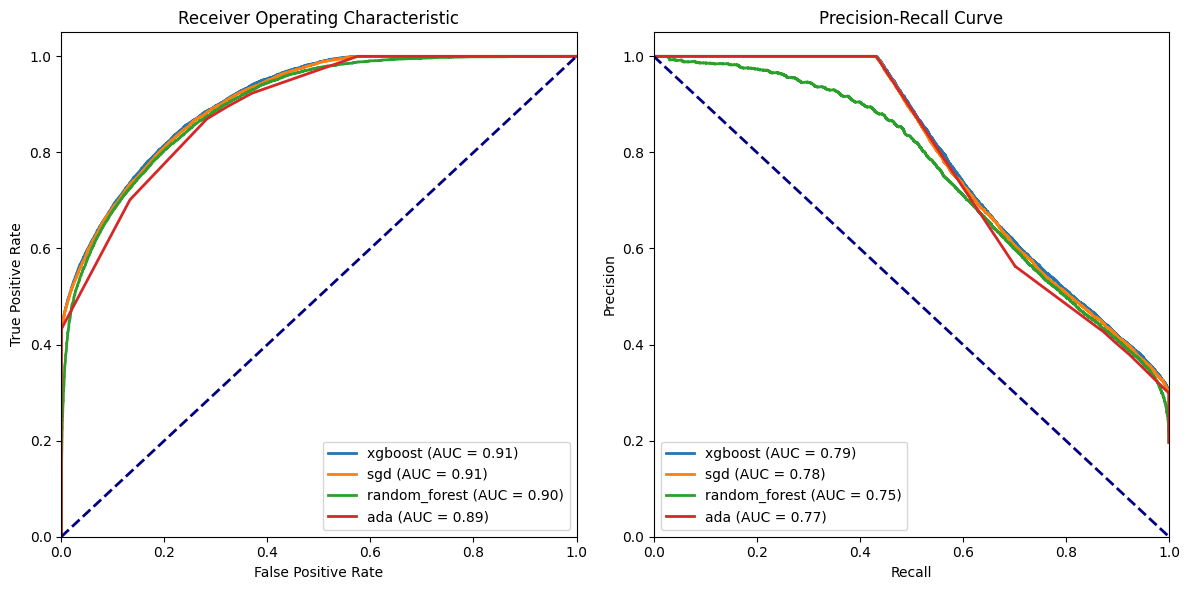

In [19]:
# Define Function to Plot ROC and PRC Curve for all models
def plot_roc_prc_curves(results_df, X_test, y_test):

    # Set Plot Size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Iterate over the models and plot the ROC and Precision-Recall curves
    for index in results_df.index:
        model_name = results_df.loc[index, 'model']
        model_data = results_df.loc[index, 'model_data']

        # Probabilities for positive class
        y_scores = model_data.predict_proba(X_test)[:, 1]

        # ROC Curve and ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

        # Precision-Recall Curve and PRC-AUC
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)
        ax2.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.2f})')

    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    ax2.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Plot ROC and PRC Curve
plot_roc_prc_curves(all_results_df, X_test_transformed, y_test)

In [20]:
# Define Function to Generate Model Evaluation Results
def model_evaluation(X_train, y_train, X_test, y_test, results_df):
  # Iterate over the models and calculate the ROC AUC score for the train and test sets
  for index, row in results_df.iterrows():
      model_name = row['model']
      model_data = row['model_data']
      best_params = row['best_params']

      print(f"\nModel {index}: {model_name}")
      print(f"Best Parameters: {best_params}\n")

      # Make predictions on the train and test set
      probas_train = model_data.predict_proba(X_train)
      preds_train = probas_train[:, 1] # Extract probabilities for positive class

      probas_test = model_data.predict_proba(X_test)
      preds_test = probas_test[:, 1] # Extract probabilities for positive class

      y_pred = model_data.predict(X_test)

      # Calculate evaluation metrics
      roc_auc_train = roc_auc_score(y_train, preds_train)
      roc_auc_test = roc_auc_score(y_test, preds_test)

      # Update the results dataframe
      results_df.loc[index, 'roc_auc_train'] = roc_auc_train
      results_df.loc[index, 'roc_auc_test'] = roc_auc_test

      # Calculate precision-recall curve on test set
      prc = precision_recall_curve(y_test, preds_test)
      precisions, recalls, thresholds = prc
      prc_auc_test = auc(recalls, precisions)
      results_df.loc[index, 'prc_auc_test'] = prc_auc_test

      prc_df = pd.DataFrame(prc)
      prc_df = prc_df.T
      prc_df.columns = ['precision', 'recall', 'threshold']

      # Calculate F1 scores and find index of highest F1 score
      prc_df['Precision_Recall'] = prc_df['precision'] - prc_df['recall']
      prc_df['F1_Score'] = 2 * (prc_df['precision'] * prc_df['recall']) / (prc_df['precision'] + prc_df['recall'])
      prc_df['F1_Score'] = prc_df['F1_Score'].fillna(0)

      # Threshold with highest F1 Score
      highf1_idx = prc_df.loc[prc_df['F1_Score'].idxmax()]
      highf1_threshold = highf1_idx['threshold']
      highf1 = highf1_idx['F1_Score']
      highf1_precision = highf1_idx['precision']
      highf1_recall = highf1_idx['recall']

      # Threshold with lowest absolute Precision-Recall difference
      best_threshold_prc = prc_df['Precision_Recall'].abs()
      best_threshold_prc = prc_df.loc[best_threshold_prc.idxmin()]

      print(f"Best Threshold with Highest F1 Score {highf1:.4f} (Threshold: {highf1_threshold:.4f})")
      print(f"Best Threshold with Balanced F1 Score {best_threshold_prc['F1_Score']:.4f} (Threshold: {best_threshold_prc['threshold']:.4f})")

      # Calculate F1 score for best threshold
      y_pred = (preds_test >= highf1_threshold).astype(int)
      optimal_f1 = f1_score(y_test, y_pred)

      results_df.loc[index, 'F1 score'] = optimal_f1
      results_df.loc[index, 'Precision'] = highf1_precision
      results_df.loc[index, 'Recall'] = highf1_recall
      results_df.loc[index, 'Threshold'] = highf1_threshold

  results_df_sorted = results_df.sort_values(by='roc_auc_test', ascending=False)
  results_df_sorted = results_df_sorted.reset_index(drop=True)

  print(f'\n--------- ROC-AUC Scores ---------\n')
  print(results_df_sorted[['model', 'roc_auc_train', 'roc_auc_test', 'prc_auc_test']])

  print(f'\n--------- F1 Scores & Threshold  ---------\n')
  print(results_df_sorted[['model','F1 score', 'Precision', 'Recall', 'Threshold']])

  return results_df_sorted


# Generate Model Evaluation Results
results_df_sorted = model_evaluation(X_train=X_train_transformed, y_train=y_train, X_test=X_test_transformed, y_test=y_test, results_df=all_results_df)



Model 3: xgboost
Best Parameters: {'model__n_estimators': 100, 'model__eta': 0.1}

Best Threshold with Highest F1 Score 0.6631 (Threshold: 0.6695)
Best Threshold with Balanced F1 Score 0.6602 (Threshold: 0.6346)

Model 2: sgd
Best Parameters: {'model__penalty': 'l1', 'model__n_jobs': -1, 'model__loss': 'log_loss', 'model__learning_rate': 'adaptive', 'model__eta0': 0.1}

Best Threshold with Highest F1 Score 0.6606 (Threshold: 0.6736)
Best Threshold with Balanced F1 Score 0.6593 (Threshold: 0.6264)

Model 0: random_forest
Best Parameters: {'model__n_jobs': -1, 'model__n_estimators': 100, 'model__max_depth': 30}

Best Threshold with Highest F1 Score 0.6536 (Threshold: 0.6375)
Best Threshold with Balanced F1 Score 0.6526 (Threshold: 0.6286)

Model 1: ada
Best Parameters: {'model__n_estimators': 500, 'model__learning_rate': 0.1, 'model__algorithm': 'SAMME'}

Best Threshold with Highest F1 Score 0.6247 (Threshold: 0.5123)
Best Threshold with Balanced F1 Score 0.6246 (Threshold: 0.5165)

---

#### Lift Curves Analysis

A lift curve is a useful tool for evaluating the performance of a classification model, particularly in scenarios where we are interested in targeting a specific subset of th population with the highest likelihood of defaulting the loan (positive class).

**Understanding the Axes:**

* **X-axis:** Represents the percentage of the total population, ordered by the predicted probability of belonging to the positive class (from highest to lowest). For example, the left-most side of x-axis represents borrowers that have the highest predicted probabilities of defaulting. Hence, a high values in y-axis means most of these high potential defaulters are identified by the predictive models.
* **Y-axis:** Represents the "lift," which is the ratio of the proportion of true positive instances in the targeted group (X-axis) to the proportion of positive instances in the entire population.

**Interpretation:**

* **The higher the lift, the better:** A lift value greater than 1 indicates that the model is performing better than random selection in identifying positive instances within the targeted group. The higher the lift, the more effective the model is at concentrating positive instances at the beginning of the targeted population.
* **The steeper the initial slope, the better:** A steep initial slope means the model is very good at identifying the most likely positive instances. This is crucial in this scenarios, where we want to focus mitigating actions on the loan borrowers who have high likelihoon to default their loans.
* **The longer the lift stays high, the better:** A flat lift curve at a high level indicates that the model is consistently good at identifying positive instances across a larger portion of the targeted population.
* **Comparison with the baseline:** The baseline (diagonal line) represents the performance of a random classifier or a random person guessing if the loan borrowers will default their loan repayment. The model's lift curve should ideally be significantly above the baseline, demonstrating its superior performance.


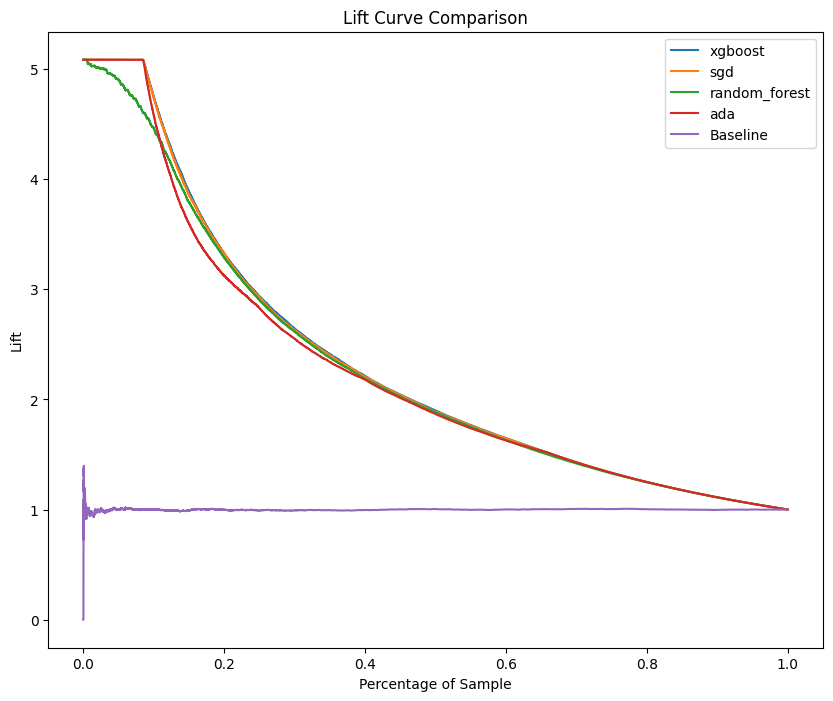

In [21]:
# Define Function to Plot Lift Curve
def plot_lift_curve(y_true, y_probas, model_name):
    # Calculate the cumulative gains
    sorted_indices = np.argsort(y_probas[:, 1])[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    percentages = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
    
    # Calculate the lift
    lift = cumulative_gains / percentages
    
    # Plot the lift curve
    plt.plot(percentages, lift, label=model_name)


# Train each model and plot their lift curve
plt.figure(figsize=(10, 8))

for index in all_results_df.index:
    model_name = all_results_df.loc[index, 'model']
    model_data = all_results_df.loc[index, 'model_data']

    # Get predicted probabilities
    y_probas = model_data.predict_proba(X_test_transformed)
    plot_lift_curve(y_test, y_probas, model_name)

# Get predicted probabilities for baseline model
baseline_probas = baseline_model.predict_proba(X_test_transformed)
plot_lift_curve(y_test, baseline_probas, 'Baseline')

plt.xlabel('Percentage of Sample')
plt.ylabel('Lift')
plt.title('Lift Curve Comparison')
plt.legend()
plt.show()


* **All models outperform the baseline:** The lift curves for all the models are significantly higher than the baseline (flat line at lift = 1) for a large portion of the test data samples, indicating all models are doing a better job at predicting the positive class than random guessing.

* **Early Lift is crucial:** The steepness of the curves at the beginning (left side) indicates how well each model identifies the instances with the highest probability of belonging to the positive class. A steeper initial slope is desirable, especially in scenarios where we want to target a small, high-potential loan borrowers likely to default on their loan repayments.

**Model-Specific Observations**

* **XGBoost & SGD:** These two models exhibit the highest lift initially, suggesting they are particularly effective at identifying the most likely positive instances. XGBoost seems to have a slight edge over SGD in the very beginning.

* **Random Forest:** While it doesn't have the highest initial lift, it maintains a relatively high lift for a larger portion of the sample compared to SGD and ADA. This suggests it's good at consistently identifying positive instances across a wider range.

* **ADA:** It has a lower lift compared to the other models, particularly in the early part of the curve. This indicates it might not be as effective in pinpointing the most likely positive instances.

#### Values At Risk Analysis

##### Conceptual Framework

**False Negatives and Lost Loan Value**:

For each false negative (a loan predicted to be good but actually defaults) results in a loss equal to the loan's default value.
The total lost value due to false negatives represents the potential financial risk to the lenders associated with the model's misclassifications. We give a term for this as `Loan Value at Risk (VaR)`:

In theory, VaR is a statistical measure that estimates the potential loss in value of a portfolio or asset over a specific time period, at a given confidence level (https://www.investopedia.com/articles/04/092904.asp#:~:text=Value%20at%20Risk%20(VaR)%20is,size%20of%20the%20possible%20loss.). In this context, we'll adapt VaR to estimate the potential loss due to false negatives for each model.

**Hypothetical Savings**:
By comparing the VaR of different models, we can estimate the potential savings each model could achieve by reducing the number of false negatives.

**Implementation Steps**
**Model Predictions and True Labels**:
1. **Identify False Negatives** via the predicted probabilities or class labels from each classification model.
2. Identify and sum up **Default Loan Value** for Each Model from false negatives.
3. Calculate **VaR**:
    - Sort the filtered values for each model in descending order.
    - Based on a chosen a confidence level (e.g., 95%), based on the `np.percentile()` of the sorted data. The VaR at the chosen confidence level is the lost value at the corresponding percentile (e.g., 95th percentile for 95% VaR).

**Compare the VaR values for different models**
The model with the lower VaR is potentially more effective in reducing financial risk due to false negatives.
Calculate the hypothetical savings between models as the difference in their VaR values.

In [45]:
# Lists to store results
total_loss_values = []
var_values = []
confidence = 95

# Define function to calculate VaR and Lost Opportunity Values based on model predicted probabilities with threshold
def calculate_var(model, model_name, X_test, y_test, principal = X_test_loan_amnt, threshold=0.5, confidence = 95):
    # Predict on the test set based on threshold
    y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)

    # Calculate values for false negatives (VaR)
    false_negatives_mask = (y_test == 1) & (y_pred == 0)
    
    lost_values = principal[false_negatives_mask].values
    total_loss = np.sum(lost_values)

    var_95 = np.sum(np.percentile(lost_values, confidence))  # 99th percentile VaR
    total_var_95 = np.sum(lost_values[lost_values <= var_95])

    return total_loss, total_var_95

# Iterate through models in result_df
for index, row in results_df_sorted.iterrows():
    model_name = row['model']
    model = row['model_data']
    threshold = row['Threshold']

    # Calculate VaR
    values = calculate_var(model, model_name, X_test_transformed, y_test, threshold=threshold, confidence=confidence)
    total_loss_values.append(values[0])
    var_values.append(values[1])

# Handle the baseline model separately
baseline_values = calculate_var(baseline_model, "Baseline", X_test_transformed, y_test)
total_loss_values.append(baseline_values[0])
var_values.append(baseline_values[1])

# Convert into a DataFrame with model names
model_names = results_df_sorted['model'].tolist() + ['Baseline']
var_df = pd.DataFrame({'Total_Loss': total_loss_values,
                        'VaR': var_values
                        }, index=model_names)


In [47]:
var_df.T

,xgboost,sgd,random_forest,ada,Baseline
Total_Loss,66825950.0,68444475.0,62389900.0,50206925.0,94205900.0
VaR,58491550.0,60085400.0,54629125.0,45277950.0,83402775.0


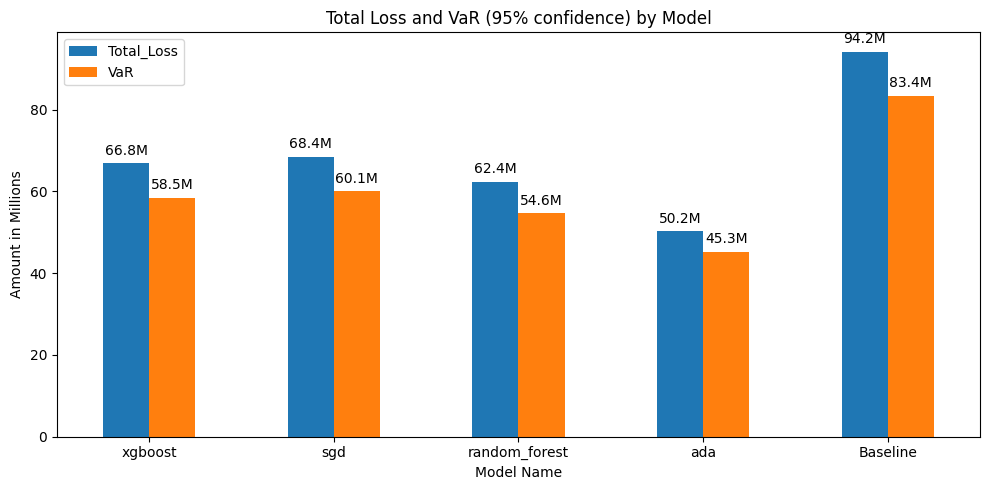

In [46]:
# Convert values to millions
df_millions = var_df / 1e6

# Plotting
ax = df_millions.plot(kind='bar', figsize=(10, 5))

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}M',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), textcoords='offset points')

# Adding labels and title
ax.set_xlabel('Model Name')
ax.set_ylabel('Amount in Millions')
ax.set_title(f'Total Loss and VaR ({confidence}% confidence) by Model')
plt.xticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

In [50]:
# Calculating percentage improvement over the Baseline
baseline_total_loss = var_df.loc['Baseline', 'Total_Loss']
baseline_var = var_df.loc['Baseline', 'VaR']

var_df['Total_Loss_Improvement (%)'] = ((baseline_total_loss - var_df['Total_Loss']) / baseline_total_loss) * 100
var_df['VaR_Improvement (%)'] = ((baseline_var - var_df['VaR']) / baseline_var) * 100

# Displaying the DataFrame with improvements
var_df[['Total_Loss_Improvement (%)', 'VaR_Improvement (%)']]

,Total_Loss_Improvement (%),VaR_Improvement (%)
xgboost,29.063944,29.868581
sgd,27.345872,27.957553
random_forest,33.772832,34.499631
ada,46.705116,45.711698
Baseline,0.000000,0.000000


**Total Loss (Loan Values from False Negatives) and VaR (Loan Principal Values at Risk at 95% Confidence)**:
   - The **Baseline** model represents the loan values from all the False Negatives from Test datasets when using a random dummy classifier.
   - **AdaBoost** achieves the lowest Total Loss, indicating that it is the most effective model in minimizing False Negatives, i.e., it correctly predicts defaults more frequently than other models. It also shows the highest percentage improvement over the Baseline model, making it the most effective model in this comparison at minimising potential financial losses and risk.
   - **XGBoost**, although achived the highest test ROC-AUC scores, but are less effective than AdaBoost.

#### Best Model (After Evaluation with Test Data)

In [78]:
print('\n--------- Best Model (After Evaluation with Test Data) ---------\n')

selected_model = 'xgboost'
#selected_model = 'ada'

# index of the selected model
index = results_df_sorted[results_df_sorted['model'] == selected_model].index[0]

# Print the best model
print('\n--------- Best Model ---------\n')
print (f"Best Model: {results_df_sorted.loc[index]['model']}")
print (f"Best Parameters: {results_df_sorted.iloc[index]['best_params']}")

print('\n------------------------------------\n')

# Save the best model
best_model_data = results_df_sorted.iloc[index]['model_data']
dump(best_model_data, 'best_model.joblib')
print('Best Model Saved')


--------- Best Model (After Evaluation with Test Data) ---------


--------- Best Model ---------

Best Model: xgboost
Best Parameters: {'model__n_estimators': 100, 'model__eta': 0.1}

------------------------------------

Best Model Saved


### Threshold Fine-Tuning

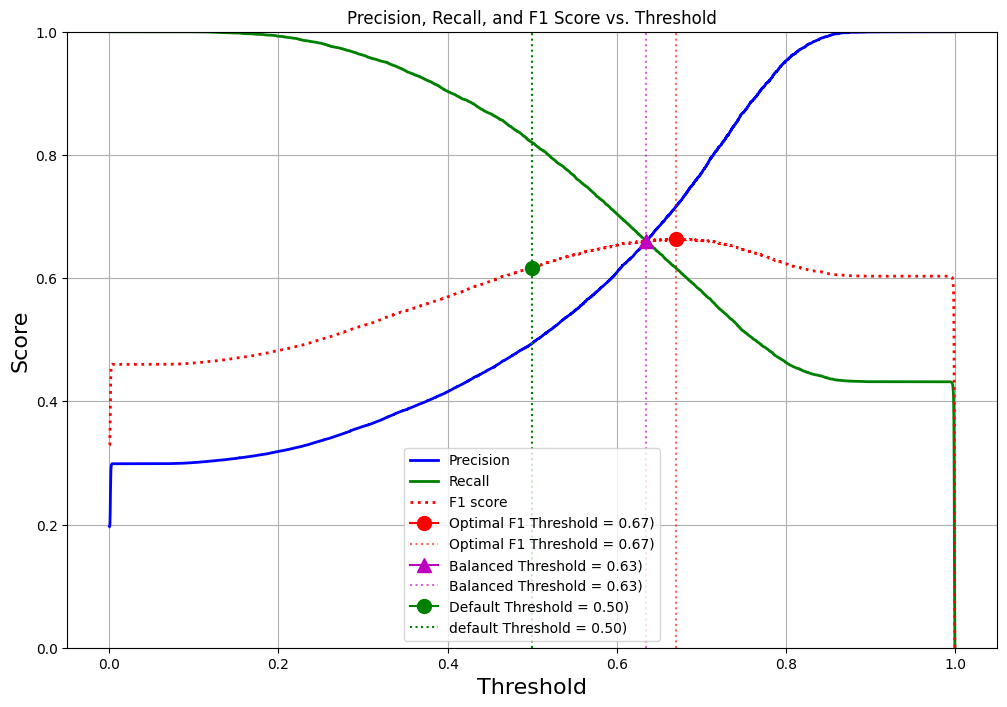

Balanced Threshold: 0.635 
Balanced F1 Score: 0.660

Optimal Threshold: 0.669 
Optimal F1 Score: 0.663


In [79]:
# Define Function for Threshold Fine-Tuning
def threshold_fine_tuning(model_data, X_test, y_test):

  # Make predictions on the test set with Best Model
  probas_test = best_model_data.predict_proba(X_test)
  preds_test = probas_test[:, 1] # Extract probabilities for positive class

  # Set Plot Size
  plt.figure(figsize=(12, 8))
  colour = ['r', 'b']
  highf1_thresholds = []

  # Calculate precision-recall curve
  prc = precision_recall_curve(y_test, preds_test)
  precisions, recalls, thresholds = prc

  prc_df = pd.DataFrame(prc)
  prc_df = prc_df.T

  # Assign column names to prc_df
  prc_df.columns = ['precision', 'recall', 'threshold']

  # Calculate F1 scores and find index of highest F1 score
  prc_df['Precision_Recall'] = prc_df['precision'] - prc_df['recall']
  prc_df['F1_Score'] = 2 * (prc_df['precision'] * prc_df['recall']) / (prc_df['precision'] + prc_df['recall'])
  prc_df['F1_Score'] = prc_df['F1_Score'].fillna(0)

  # Threshold with highest F1 Score
  highf1_idx = prc_df.loc[prc_df['F1_Score'].idxmax()]
  highf1_threshold = highf1_idx['threshold']
  highf1 = highf1_idx['F1_Score']

  # Calculate F1 score for best threshold
  y_pred = (preds_test >= highf1_threshold).astype(int)
  optimal_f1 = f1_score(y_test, y_pred)

  # Threshold with balanced precision-recall
  balanced_idx = prc_df.loc[prc_df['Precision_Recall'].abs().idxmin()]
  balanced_threshold = balanced_idx['threshold']
  balanced_prc = balanced_idx['F1_Score']

  # Calculate F1 score for balanced threshold
  y_pred_balanced = (preds_test >= balanced_threshold).astype(int)
  balanced_f1 = f1_score(y_test, y_pred_balanced)

  # Calculate F1 score for defaut threshold
  y_pred_default = best_model_data.predict(X_test)
  default_f1 = f1_score(y_test, y_pred_default)
  default_threshold = 0.5
  
  # Plot precision, recall, best and balanced threshold marker
  plt.plot(prc_df['threshold'], prc_df['precision'], label=f"Precision", linewidth=2, color='b')
  plt.plot(prc_df['threshold'], prc_df['recall'], label=f"Recall", linewidth=2, color='g')
  plt.plot(prc_df['threshold'], prc_df['F1_Score'], label=f"F1 score", linestyle=':', color='r', linewidth=2)

  plt.plot(highf1_threshold, optimal_f1, color='r', marker='o', ms = 10.0, label=f'Optimal F1 Threshold = {highf1_threshold:.2f})')
  plt.axvline(x=highf1_threshold, color='r', linestyle=':', alpha = 0.6, label=f'Optimal F1 Threshold = {highf1_threshold:.2f})')

  plt.plot(balanced_threshold, balanced_f1, color='m', marker='^', ms = 10.0, label=f'Balanced Threshold = {balanced_threshold:.2f})')
  plt.axvline(x=balanced_threshold, color='m', linestyle=':', alpha = 0.6, label=f'Balanced Threshold = {balanced_threshold:.2f})')

  plt.plot(default_threshold, default_f1, color='g', marker='o', ms = 10.0, label=f'Default Threshold = {default_threshold:.2f})')
  plt.axvline(x=default_threshold, color='g', linestyle=':', alpha = 1.0, label=f'default Threshold = {default_threshold:.2f})')


  plt.title(f'Precision, Recall, and F1 Score vs. Threshold')
  plt.xlabel("Threshold", fontsize=16)
  plt.ylabel("Score", fontsize=16)
  plt.legend(loc="best", fontsize=10)
  plt.grid(True)
  plt.ylim([0, 1])
  plt.show()

  print(f'Balanced Threshold: {balanced_threshold:.3f} ')
  print(f'Balanced F1 Score: {balanced_f1:.3f}\n')

  print(f'Optimal Threshold: {highf1_threshold:.3f} ')
  print(f'Optimal F1 Score: {optimal_f1:.3f}')

  return highf1_threshold, balanced_threshold, default_threshold


# Fine-tune the threshold
highf1_threshold, balanced_threshold, default_threshold = threshold_fine_tuning(best_model_data, X_test_transformed, y_test)


### Classification Report and Confusion Matrix


========== xgboost: Based on Highest Probability ==========

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     50728
           1       0.49      0.82      0.62     12418

    accuracy                           0.80     63146
   macro avg       0.72      0.81      0.74     63146
weighted avg       0.86      0.80      0.82     63146


========== xgboost: Highest F1 Score Threshold: 0.669 ==========

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     50728
           1       0.72      0.62      0.66     12418

    accuracy                           0.88     63146
   macro avg       0.81      0.78      0.79     63146
weighted avg       0.87      0.88      0.87     63146


========== xgboost: Balanced Precision vs Recall Threshold: 0.635 ==========

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     50728
           1       0.66      

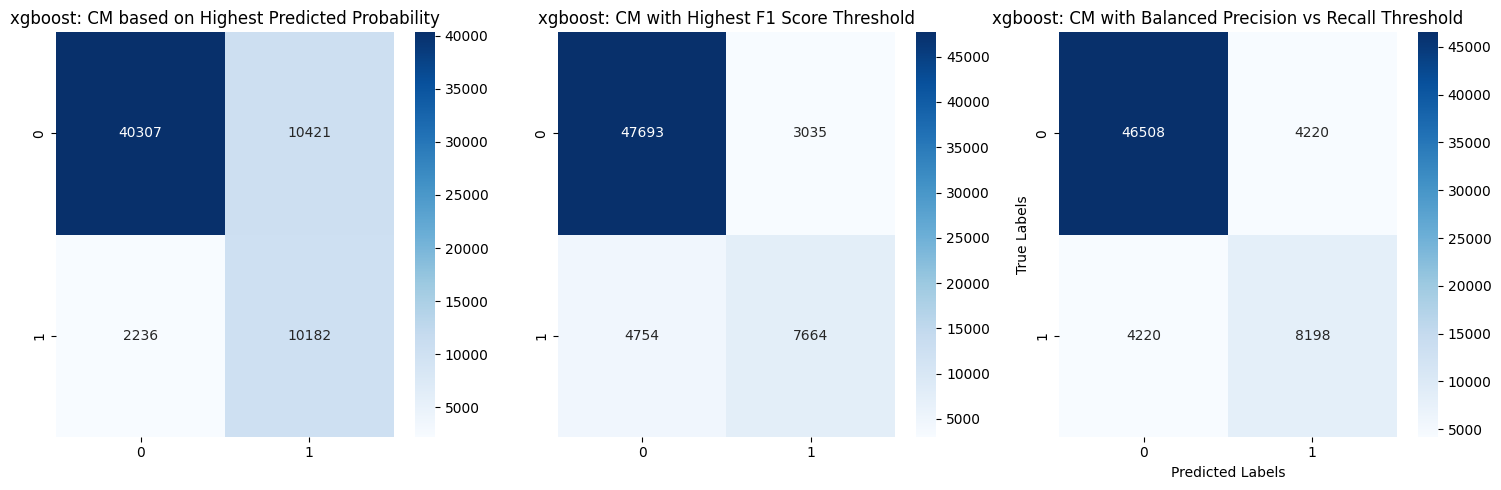

In [80]:
# Define Function to Generate Classification Report with the Thresholds
def print_cm_threshold(model_data, X_test, y_test, highf1_threshold, balanced_threshold):

  # Get the predictions based on highest probability
  org_y_pred = model_data.predict(X_test)

  print(f'\n========== {selected_model}: Based on Highest Probability ==========\n')
  print(classification_report(y_test, org_y_pred))

  # Make predictions on the test set with Best Model
  probas_test = best_model_data.predict_proba(X_test)
  preds_test = probas_test[:, 1] # Extract probabilities for positive class

  print(f'\n========== {selected_model}: Highest F1 Score Threshold: {highf1_threshold:.3f} ==========\n')
  y_pred_f1 = (preds_test >= highf1_threshold).astype(int)
  print(classification_report(y_test, y_pred_f1))

  print(f'\n========== {selected_model}: Balanced Precision vs Recall Threshold: {balanced_threshold:.3f} ==========\n')
  y_pred_bal = (preds_test >= balanced_threshold).astype(int)
  print(classification_report(y_test, y_pred_bal))

  # Confusion Matrix
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

  cm = confusion_matrix(y_test, org_y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)

  opt_cm = confusion_matrix(y_test, y_pred_f1)
  sns.heatmap(opt_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
  
  bal_cm = confusion_matrix(y_test, y_pred_bal)
  sns.heatmap(bal_cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
  
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  
  ax1.set_title(f'{selected_model}: CM based on Highest Predicted Probability')
  ax2.set_title(f'{selected_model}: CM with Highest F1 Score Threshold')
  ax3.set_title(f'{selected_model}: CM with Balanced Precision vs Recall Threshold')

  plt.tight_layout()
  plt.show()

# Generate Classification Report with the Optimal Threshold
print_cm_threshold(best_model_data, X_test_transformed, y_test, highf1_threshold, balanced_threshold)


### Deployment

The Model is deployed into a Streamlit App and can be access here: 
https://lendingclubiti105project.streamlit.app

In [81]:
vec_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('emp', Word2VecVectorizer(vector_size=120),
                                 'emp_title_clean'),
                                ('purpose', Word2VecVectorizer(vector_size=60),
                                 'title_purpose')])

In [82]:
best_model_data

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['int_rate', 'emp_length', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'n_term', 'total_interest', 'n_installmt',...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

### Model Interpretation

In [83]:
# Extract Features from Preprocessor
vector_feature_names = vec_preprocessor.get_feature_names_out()
pattern = re.compile(r'remainder__')
vector_feature_names = [pattern.sub('', i ) for i in vector_feature_names]

X_transformed = vec_preprocessor.transform(X_train)
X_df = vec_to_df(X_train, X_transformed, vec_preprocessor)
# X_df = pd.DataFrame(X_transformed, columns = vector_feature_names)

model_pipeline = all_results_df.iloc[0]['model_data'] # Select Model Data
feature_names_transformed = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names_transformed = [pattern.sub('', i ) for i in feature_names_transformed]
X_encoded_df = pd.DataFrame(X_df, columns=feature_names_transformed)

print(f'Shape of Preprocessed output data X: {X_encoded_df.shape}')

# Map Original Feature to Transformed Feature after Preprocessing
feature_original = {}

for original_feature in X_train.columns:
    if X_train[original_feature].dtype == 'object' or X_train[original_feature].dtype is np.dtype('O'):
        # This is for handling categorical columns that are typically one-hot encoded
        encoded_features = [col for col in feature_names_transformed if col.startswith("cat__"+original_feature + '_')]
        for feature in encoded_features:
            feature_original[feature] = original_feature
    else:
        # This is for handling numerical columns that are typically scaled or imputed
        feature_original[original_feature] = original_feature

# Check if model has feature improtance of coefficients
if model_pipeline and hasattr(model_pipeline, 'named_steps') and 'model' in model_pipeline.named_steps:
  model_step = model_pipeline.named_steps['model']

  if hasattr(model_step, 'feature_importances_'):
    importances = model_step.feature_importances_
  elif hasattr(model_step, 'coef_'):
    importances = np.abs(model_step.coef_.flatten()) # Flatten in case of multi-dimensional coef_
  else:
    raise ValueError("Model does not have feature_importances_ or coef_ attribute.")

else:
  raise ValueError("The model pipeline is not correctly configured with 'named_steps'.")

# List out the columns names for Preprocessed X
features = [col for col in X_encoded_df.columns]  # Assuming X_encoded_df is a DataFrame

features_data = {"Encoded Feature": features,
                 "Original Feature": [feature_original.get(f, f) for f in features],
                 "Importance": importances
                 }

df_features = pd.DataFrame(features_data)
df_features['Original Feature'] = df_features['Original Feature'].str.replace(r'num__', '', regex=True)
df_features['Original Feature'] = df_features['Original Feature'].str.replace(r'cat__', '', regex=True)
df_features['Original Feature'] = df_features['Original Feature'].str.split('__').str[0]

if hasattr(model_step, 'feature_importances_'):
    df_features = df_features.groupby("Original Feature")['Importance'].sum().reset_index()
    # Sum of Importance for df_feature
    print(f'Sum of Feature Importance: {df_features["Importance"].sum()}')
else: # Coefficients
    df_features = df_features.groupby("Original Feature")['Importance'].mean().reset_index()

df_features = df_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)

df_features

Shape of Preprocessed output data X: (99348, 271)
Sum of Feature Importance: 1.0


,Original Feature,Importance
0,postal_code,0.517575
1,emp,0.156386
2,grade_enc,0.097277
3,purpose,0.092307
4,n_term,0.045776
5,int_rate,0.019433
6,state,0.016874
7,home_ownership,0.015027
8,dti,0.007125
9,annual_inc,0.005301


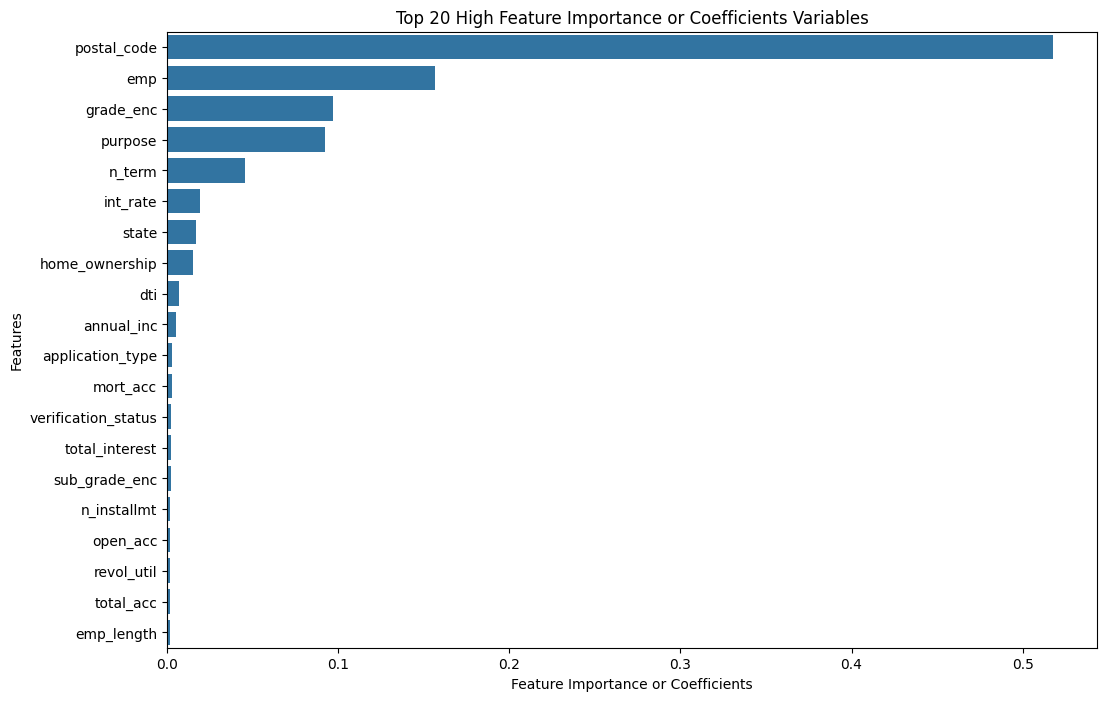

In [84]:
# Plotting top 10 features by importance or coefficient magnitude
n_features = 20

df_importance = df_features.head(n_features)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Original Feature', data=df_importance)
plt.title(f'Top {n_features} High Feature Importance or Coefficients Variables')
plt.xlabel('Feature Importance or Coefficients')
plt.ylabel('Features')
plt.show()


The key insight from the feature importance analysis is that geographic location (`postal_code`) and borrower stability factors like employment (`emp`) are the most critical predictors of loan defaults, overshadowing traditional financial metrics like the debt-to-income ratio (`dti`). 

The relatively low importance of `dti`,  `grade_enc` (loan grade), `int_rate` (interest rate) `annual_inc` (annual income) and `home_ownership` implies that once a borrower has been approved, these factors contribute less to predicting whether they will default, possibly because approved borrowers have already demonstrated a sufficient level of financial stability and already passed preliminary creditworthiness checks. As a result, these borrowers may have already met the minimum thresholds, thus, making traditional measures like `dti` less predictive. This suggests that while traditional heuristic is crucial in the initial screening, other factors like geographic and employment stability which are more challenging to analyse manually can become more decisive in predicting defaults among approved loans.

In [ ]:
# Backup the cvfit_results_df, results_df and model_pipeline into joblib
dump(cvfit_results_df, 'cvfit_results_df.joblib')
dump(all_results_df, 'results_df.joblib')
dump(results_df_sorted, 'results_df_sorted.joblib')